# ML1 Project: Predicting Political Ideology and Urbanization from Economic Indicators





| **Table of Contents** |  |  |
| :--- | :--- | :--- |
| - [1. Introduction](#1-introduction)<br>- [2. Data Cleaning & Preparation](#2-data-cleaning--preparation)<br>- [3. Exploratory Data Analysis (EDA)](#3-exploratory-data-analysis) | - [4. Hypotheses](#4-hypothesis)<br>- [5. Modeling](#5-building-predictive-models)<br>- [6. Results](#6-results) | - [7. Conclusions & Recommendations](#7-conclusions--recommendations)<br>- [8. AI Usage Reflection](#8-ai-usage-reflection)<br>- [9. Team Contributions](#9-team-contributions) |

In [317]:
from IPython.core.display import HTML
import pandas as pd

# Prevent scientific notation
pd.set_option('display.float_format', '{:,.2f}'.format)

# Inject CSS, now including table.dataframe styles for smaller font in DataFrame HTML outputs
HTML('''
<style>
div.text_cell_render {
    font-size: 11px;
}
div.input_area pre,
.CodeMirror pre {
    font-size: 10px !important;
    line-height: 1.3 !important;
}
div.output pre {
    font-size: 10px;
    line-height: 1.3;
}
div.output_html {
    font-size: 10px;
    line-height: 1.3;
    overflow-x: auto;
    white-space: nowrap;
}

table.dataframe {
    font-size: 10px !important;
}
table.dataframe th,
table.dataframe td {
    padding: 4px 8px !important;
}
</style>
''')



## <a id='1-introduction'></a>1. Introduction

Understanding the link between economic development and political ideology is central to political science and international economics. Previous research (Lucassen & Lubbers, 2011) highlights that economic indicators can influence voting patterns and ideological shifts, but few studies use global data and machine learning to predict regime ideology. Rickardsson (2021) suggests that there is a divide between urban and rural populations for voting characteristics. Possibly because of lower access to public services in rural areas, they respond to the deterioration of their location by casting a vote on the far-right. This can be explained by economic voting phenomena which suggests that voters hold the major incumbent party accountable for recent economic performance while voting. In addition, there is some evidence that higher levels of GDP in a country result in greater far-right preference (Lucassen &  Lubbers ,2011). In authoritarian regimes, military spending tends to be higher than in democratic regimes while right-wing governments spend more on arms purchases and left-wing governments spend more on military personnel (Carter,2016).










| **Objective** | **Research Questions** | **Ideology Definitions** |
| --- | --- | --- |
| Examine whether a country’s dominant political <br>ideology—left, center, or right—can be predicted <br>from its economic indicators (GDP, GNI, urbanization, <br>military spending, etc.). We also explore the connection <br>between ideology, democracy, and urbanization. | - Are economic indicators related to leader ideologies?<br>- Can ideology and economics predict military spending?<br>- Is urbanization linked to ideology or economic status? | 🔴 **Left:** Social equality, strong welfare (e.g., Venezuela, Cuba)<br>🟡 **Center:** Pragmatism, balance (e.g., Switzerland, Germany)<br>🔵 **Right:** Free-market focus (e.g., USA, UK) |



**Why this matters:**  
Predicting political ideology from economic data can help international organizations, NGOs, and policymakers anticipate shifts and allocate resources more effectively.

In [318]:
# Core & Data
import pandas as pd, numpy as np, math, warnings
import matplotlib.pyplot as plt, seaborn as sns
%matplotlib inline

# Sklearn
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import (
    classification_report, confusion_matrix, accuracy_score, r2_score,
    mean_squared_error, roc_auc_score, roc_curve, auc,
    RocCurveDisplay, ConfusionMatrixDisplay
)
from sklearn.decomposition import PCA

# Statsmodels
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.formula.api import glm

# PyGAM
from pygam import LinearGAM, s, f, te
import pygam

# Scipy
import scipy as sp
from scipy import sparse
from functools import reduce
from operator import add

# Scipy sparse matrix shortcut
warnings.filterwarnings('ignore')
sparse.spmatrix.A = property(lambda self: self.toarray())

## <a id='2-data-cleaning--preparation'></a>2. Data Cleaning & Preparation

| **Data Sources** | **Process Overview** | **Processed Data Scope** |
| --- | --- | --- |
| - [Global Leader Ideologies dataset](https://github.com/bastianherre/global-leader-ideologies/blob/main/README.md)<br>- [Global Economy Indicators (GEM)](https://www.kaggle.com/datasets/prasad22/global-economy-indicators)<br>- [Military Spending (World Bank)](https://data.worldbank.org/indicator/MS.MIL.XPND.GD.ZS)<br>- [Rural/Urban Population & Unemployment](https://www.kaggle.com/datasets/hassanzahid233/world-population-and-unemployment-dataset) | - Unified country names (e.g., “USA” = “United States of America”) for reliable merging<br>- Dropped rows with unclear ideology (“no info”)<br>- Reshaped military spending to long format (one row per country-year)<br>- Merged all datasets on country & year<br>- Removed rows with missing critical features for clean modeling | - **Years:** 1990–2020<br>- **Countries:** 266<br>- **Rows:** ~2,900<br>- **Features:** 25+ (economy, ideology, military, population) |

## <a id='3-exploratory-data-analysis'></a>3. Exploratory Data Analysis (EDA)

| **Key Steps** | **Guiding Questions** | **Example Visuals** |
| --- | --- | --- |
| - Examined distribution of political ideology by country and year<br>- Plotted GDP, GNI, and other key indicators by ideology<br>- Explored urbanization and military spending trends<br>- Checked for missing data and variable correlations | - Do certain ideologies dominate particular regions or years?<br>- Are economic indicators (e.g., GDP, GNI) higher for certain ideologies?<br>- How do military spending and urban/rural splits differ by ideology? | - Bar charts: ideology prevalence by region<br>- Boxplots: GDP & GNI by ideology<br>- Line plots: military spending and urbanization over time |


<div style="font-size:9px">
<b>Notes:</b> Outliers were checked and noted; missing values visualized with heatmaps; and correlations between ideology and economic, military, or urban variables are highlighted. See code and plots below.
</div>

In [319]:
%%capture

data = pd.read_csv("processed_data/new_data_with_count.csv")
data.dropna()
data.rename(columns={'Gross.National.Income.GNI..in.USD': 'gross_national_income_GNI', 'Military.expenditure....of.GDP.': 'military_expenditure','Gross.Domestic.Product..GDP.': 'GDP'}, inplace=True)
valid_ideologies = ["leftist", "rightist", "centrist"]

data= data[data["leader_ideology"].isin(valid_ideologies)]
data= data[data["hog_ideology"].isin(valid_ideologies)]
data.columns = data.columns.str.replace('.', '_', regex=False)

data.dropna()

Let's check some descriptive statistics :

In [320]:
data.describe().T.round(2).applymap(lambda x: f"{x:}")


,count,mean,std,min,25%,50%,75%,max
Unnamed: 0,2910.0,1476.28,856.49,1.0,731.25,1474.5,2219.75,2954.0
Year,2910.0,2005.4,8.78,1990.0,1998.0,2005.5,2013.0,2020.0
IMF_based_exchange_rate,2910.0,359.08,1277.38,0.0,1.0,6.46,101.45,14582.2
Population,2910.0,48749204.98,161566525.04,365392.0,4519950.0,10468939.5,29535157.5,1424929781.0
Per_capita_GNI,2910.0,11779.47,16642.16,93.0,1129.5,3831.0,15868.0,103989.0
agriculture_and_hunting_fishing_isic,2910.0,16774816838.9,67408453172.49,12912507.0,1021653827.75,3092510072.0,9782113931.0,1180000000000.0
Changes_in_inventories,2910.0,2743432604.09,13196032504.0,-151000000000.0,14743247.0,292773917.0,1512064278.75,211000000000.0
construction_isic,2910.0,25693515037.23,85260082618.56,1203692.0,442131405.25,2062127802.5,12199822055.75,1050000000000.0
Exports_of_goods_and_services,2910.0,115585746885.45,288954121385.29,31533086.0,3232241222.0,13319596868.5,82456507687.25,2720000000000.0
Gross_capital_formation,2910.0,119237823820.96,457666113007.91,-36617055.0,2190578490.75,9024694207.0,53974127303.5,6370000000000.0


We see that min year is 1990 and max is 2020 so this confirms our filter. Mean military expenditure is aroung 2 percent of GDP, In the dataset urban and rural population counts seem to be balanced. Mean GDP is 4753213e+11. Compared to other sectors, wholesale seems to be the one with the highest USD output. SD is high in construction outputs.

Visualizing correlations helps us see how variables relate, but before we need to define target and features because we have many variables right now.

In [321]:
features = ['IMF_based_exchange_rate', 'Per_capita_GNI', 'agriculture_and_hunting_fishing_isic', 'Changes_in_inventories', 'construction_isic', 'Exports_of_goods_and_services', 'Gross_capital_formation', 'Imports_of_goods_and_services', 'mining_manifacturing_isic', 'transport_storage_communication_isic', 'wholesale_trade_restaurant_hotel_isic', 'gross_national_income_GNI', 'GDP', 'military_expenditure', 'Urban_population', 'Rural_population']
X = data[features]
y = data['leader_ideology']

Except changes in inventories, all the variables are right skewed. So we do log transformations to normalize the distribution and check distribution plots:

In [322]:
selected_cols = ['IMF_based_exchange_rate','Per_capita_GNI', 'agriculture_and_hunting_fishing_isic', 'construction_isic', 'Exports_of_goods_and_services', 'Gross_capital_formation', 'Imports_of_goods_and_services', 'mining_manifacturing_isic', 'transport_storage_communication_isic', 'wholesale_trade_restaurant_hotel_isic', 'gross_national_income_GNI', 'GDP', 'military_expenditure', 'Urban_population', 'Rural_population']
# Apply log transform
df_log = data.copy()
df_log[selected_cols] = np.log1p(df_log[selected_cols])  # or np.log1p() if values may be zero
df_log_for_binomial_model = df_log.copy()

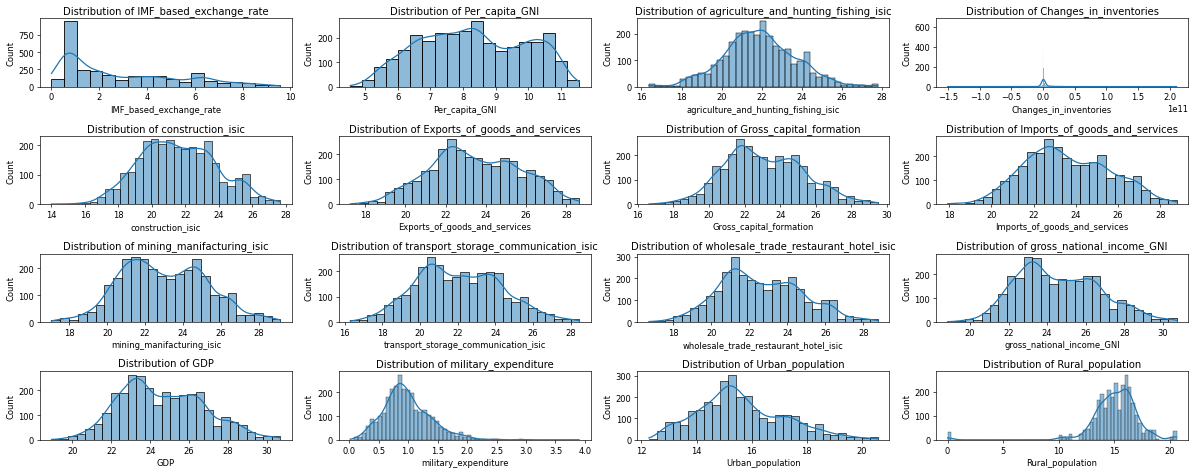

In [323]:
cols   = 4
n      = len(features)
rows   = math.ceil(n / cols)

fig, axes = plt.subplots(rows, cols, figsize=(cols * 5, rows * 2), sharex=False, sharey=False, dpi=60)

axes = axes.flatten()

for i, feature in enumerate(features):
    sns.histplot(df_log[feature], kde=True, ax=axes[i])
    axes[i].set_title(f'Distribution of {feature}')

for j in range(i + 1, rows * cols):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()

We see that after log transformation most of the variables follow a Gaussian distribution.

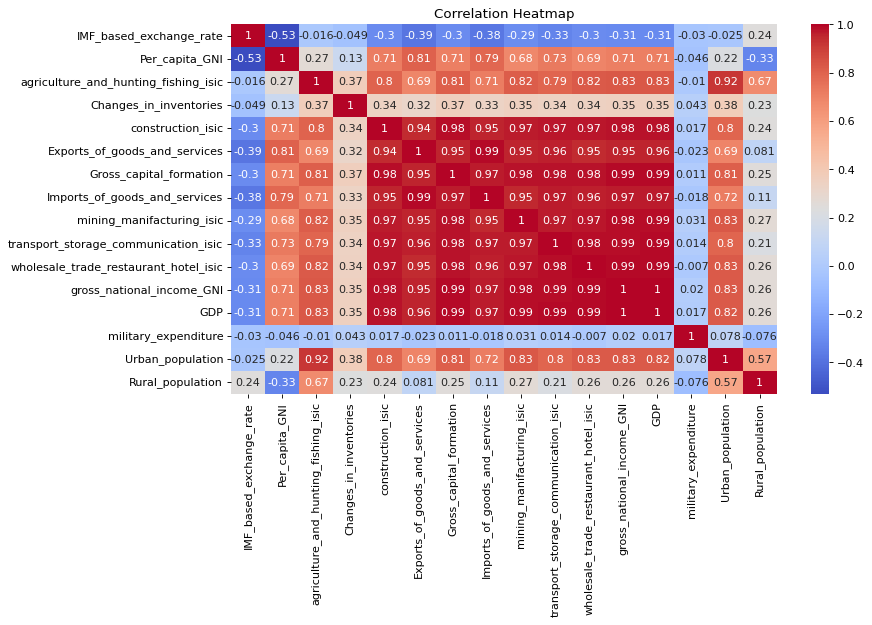

In [324]:
plt.figure(figsize=(11,6),dpi=80)
sns.heatmap(df_log[features].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

1. Strong Positive Correlations :
* **Exports vs. Imports** : Near-perfect correlation (0.99). Countries with high exports also import heavily, reflecting open economies.
* **Sectoral Shares** : Construction, mining/manufacturing, transport, and wholesale sectors are highly correlated (0.95–0.99), indicating overlapping economic activities.
* **GDP vs. Sectoral Components** : GDP is strongly tied to Gross Capital Formation (0.99) and other sectoral shares (0.96–0.99), as expected.
2. Negative Correlations :
* **Agricultural Share vs. Per Capita GNI** : Strong negative correlation (-0.31), confirming that agrarian economies tend to have lower income levels.
* **IMF Exchange Rate vs. Economic Indicators** : Weak/negative correlations (e.g., -0.53 with Per Capita GNI), suggesting limited influence on growth.
* **Military Spending** : Weakly correlated with most economic metrics (e.g., 0.02 with GDP), we assume that defense spending varies idiosyncratically.

According to our correlation plot we have high correlation among some variables. In the light of these results, we define our target variables that are related to our hypothesis as : 

    'Per_capita_GNI', 'agriculture_and_hunting_fishing_isic', 'construction_isic', 'Imports_of_goods_and_services', 'mining_manifacturing_isic' 'transport_storage_communication_isic','GDP','Urban_population','leader_ideology','democracy','military_expenditure'

## Ideology distribution


Now lets check the relationship between our variables. 

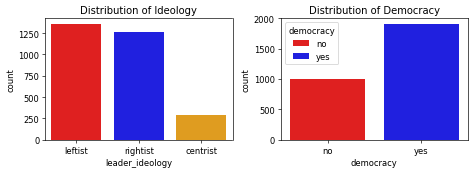

In [325]:
fig, axes = plt.subplots(1, 2, figsize=(2 * 4, 3),dpi=60)   # 3 plots × 5 in wide × 4 in tall

#  count-plot: leader_ideology
sns.countplot(
    data=df_log, x='leader_ideology', hue='leader_ideology', dodge=False, palette=['red', 'blue', 'orange'],
#     legend=False,
    ax=axes[0]
)
axes[0].set_title('Distribution of Ideology')

# count-plot: democracy
sns.countplot(
    data=df_log,
    x='democracy', hue='democracy', dodge=False, palette=['red', 'blue'],
#     legend=False,
    ax=axes[1]
)
axes[1].set_title('Distribution of Democracy')

plt.tight_layout()
plt.show()

| **Key Insight**                                                                                                                               | **Implication**                                                                                                                                                                                                                         |
| :-------------------------------------------------------------------------------------------------------------------------------------------- | :-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- |
| **Distribution of Leader Ideology**: Leftist ideology dominates the dataset, followed by rightist, with centrist being the least represented. | The dataset may reflect a historical or regional bias toward leftist governance, potentially influencing correlations with economic/military metrics (e.g., Carter’s finding that left-wing governments prioritize military personnel). |
| **Distribution of Democracy**: Democratic regimes ("yes") significantly outnumber non-democratic regimes ("no").                              | Political-economic analysis may need to account for the overrepresentation of democracies, which could mask trends in authoritarian contexts.                                                                                           |


We want to understand our target variable leader ideologies better. Below we will plot its relation with all the variables of interest:

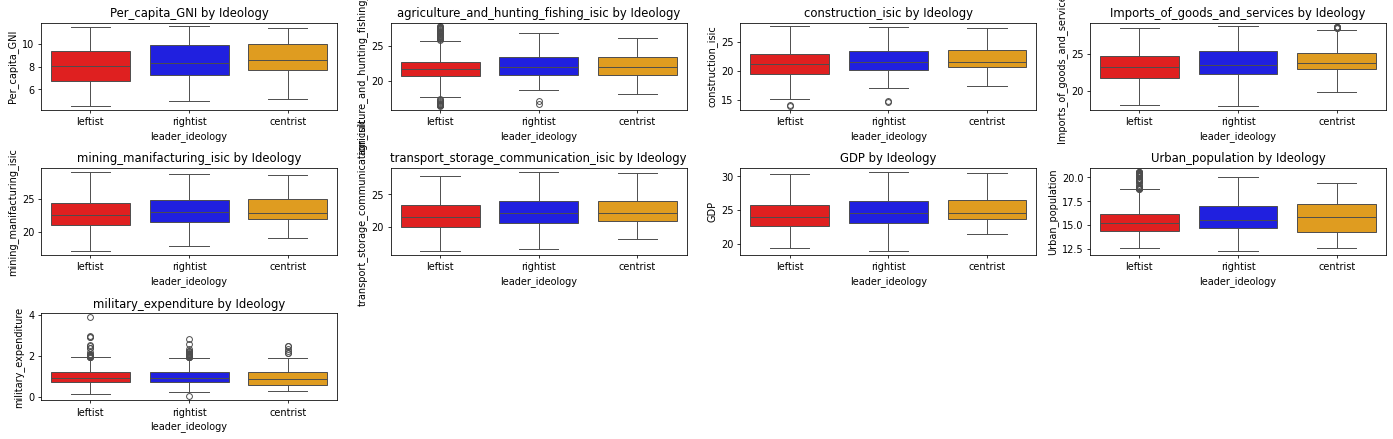

In [326]:
cols   = 4
n      = len(features)
rows   = math.ceil(n / cols)

fig, axes = plt.subplots(rows, cols, figsize=(cols * 5, rows * 2), sharex=False, sharey=False,dpi=70)

axes = axes.flatten()

columns_to_plot = [
    'Per_capita_GNI', 'agriculture_and_hunting_fishing_isic', 'construction_isic', 'Imports_of_goods_and_services', 'mining_manifacturing_isic',
    'transport_storage_communication_isic','GDP', 'Urban_population', 'military_expenditure'
]
for i, feature in enumerate(columns_to_plot):
    sns.boxplot(data=df_log, x='leader_ideology', y=feature, hue='leader_ideology', dodge=False, palette=['red', 'blue', 'orange'], legend=False, ax=axes[i])
    axes[i].set_title(f'{feature} by Ideology')

for j in range(i + 1, rows * cols):
    axes[j].set_visible(False)

plt.tight_layout()
plt.savefig("boxplots.png", dpi=300, bbox_inches="tight")
plt.show()

### Interpretation from the Plots

1. **Military Expenditure**: Rightist ideologies show higher median military spending as %GDP, which aligns with Carter's findings. This supports the hypothesis that right-wing governments spend more on arms. However, there's overlap, indicating it's not a strict rule.

2. **Per Capita GNI**: Leftist ideologies have lower per capita GNI compared to rightist and centrist. This matches the negative correlation noted earlier between agricultural share and income.

3. **Agriculture Sector**: Higher in leftist and centrist, lower in rightist, suggesting agrarian economies are more left-leaning.

4. **Exports and Imports**: Similar across ideologies, indicating trade openness isn't a distinguishing factor here.

5. **Urban Population**: Centrists have higher urban populations, which might relate to economic development.

Now let's check the relationship of military expenditure and per capita gni grouped by democracy and leader ideologies.

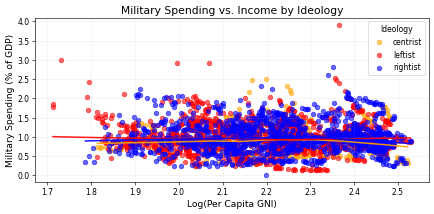

In [327]:
# Ensure log-transformed column exists
df_log['log_GNI'] = np.log1p(df_log['Per_capita_GNI']) if 'log_GNI' not in df_log.columns else df_log['log_GNI']

# Color palette
palette = {"leftist": "red", "rightist": "blue", "centrist": "orange"}

# Initialize plot
plt.figure(figsize=(8, 4), dpi=55)

# Plot scatter and trend lines
for ideology in sorted(df_log['leader_ideology'].unique()):
    subset = df_log[df_log['leader_ideology'] == ideology]
    plt.scatter(subset['log_GNI'], subset['military_expenditure'], label=ideology, color=palette[ideology], alpha=0.6)
    sns.regplot(x='log_GNI', y='military_expenditure', data=subset, scatter=False,
                lowess=True, line_kws={'lw': 2, 'alpha': 0.9}, color=palette[ideology])

plt.xlabel("Log(Per Capita GNI)", fontsize=12)
plt.ylabel("Military Spending (% of GDP)", fontsize=12)
plt.title("Military Spending vs. Income by Ideology", fontsize=14)
plt.legend(title="Ideology", fontsize=10)
plt.grid(True, alpha=0.2)
plt.tight_layout()
plt.show()


### Interpretation from the Scatter Plot
1. **Rightist Regimes** : High military spending in low-income contexts (aligns with Carter’s findings).
2. **Leftist Regimes** : Moderate spending across incomes, suggesting focus on social welfare.
3. **Centrist Regimes** : Stable, moderate spending linked to democratic stability.

### Possible Hypotheses
1. **"Higher income → lower military spending."**
* Insight : The plot shows rightist regimes in low-income contexts often have high military spending, while leftists cluster in moderate-spending, low-income contexts. Centrists show moderate spending across incomes.

In [328]:
%%capture

print(df_log['democracy'].unique())  # Check unique values
df_log['democracy'] = df_log['democracy'].replace('nan', np.nan)
print(df_log['democracy'].unique())  # Check unique values
print(df_log['leader_ideology'].unique())  # Check unique values

df_log = df_log.dropna(subset=['democracy'])
print(df_log['democracy'].unique())  # Check unique values
print(df_log.columns)

# Convert 'democracy' to lowercase strings and map 'yes'/'no' to True/False
df_log['democracy'] = df_log['democracy'].astype(str).str.lower().map({
    'yes': True,
    'no': False
})


| **Cleaning Step** | **Rationale/Implication** |
| :--- | :--- |
| Original `democracy` values: `['no', 'yes', nan]` | Dataset included string labels and missing values, requiring standardization. |
| Replaced `'nan'` with actual `NaN` | Ensures proper recognition of missing values using standard Pandas handling. |
| Dropped rows with missing `democracy` values | Eliminates ambiguity and maintains binary integrity of the variable. |
| Final `democracy` values: `['no', 'yes']` | Cleaned and suitable for binary classification tasks. |
| `leader_ideology` categories retained: `'leftist'`, `'rightist'`, `'centrist'` | Maintains ideological diversity while ensuring consistent label quality. |
| Through this we prepared `democracy` as a binary variable for modeling | Ensures clarity and statistical reliability when comparing democracies vs. autocracies or modeling political patterns. |

Now we can plot miltary expenditure, income and democracy relationship:


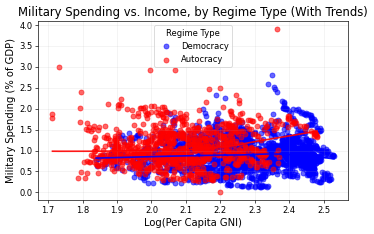

In [329]:

if 'log_GNI' not in df_log.columns:
    df_log['log_GNI'] = np.log1p(df_log['Per_capita_GNI'])  # Log-transform Per_capita_GNI

# Define colors
custom_palette = {
    True: "blue",   # Democracy
    False: "red"  # Autocracy
}

# Plot setup
plt.figure(figsize=(6, 4),dpi=60)

# Scatter points with transparency
for democracy in [True, False]:
    subset = df_log[df_log['democracy'] == democracy]
    plt.scatter(
        subset['log_GNI'],
        subset['military_expenditure'],
        label="Democracy" if democracy else "Autocracy",
        color=custom_palette[democracy],
        alpha=0.6  # Transparency for overlapping points
    )

# Add LOWESS trend lines (non-parametric smoothing)
for democracy in [True, False]:
    subset = df_log[df_log['democracy'] == democracy]
    sns.regplot(
        x=subset['log_GNI'],
        y=subset['military_expenditure'],
        scatter=False,  # Hide scatter points (already plotted)
        line_kws={'lw': 2, 'alpha': 0.9},
        lowess=True,
        color=custom_palette[democracy]
    )

plt.xlabel("Log(Per Capita GNI)", fontsize=12)
plt.ylabel("Military Spending (% of GDP)", fontsize=12)
plt.title("Military Spending vs. Income, by Regime Type (With Trends)", fontsize=14)
plt.legend(title="Regime Type", fontsize=10)
plt.grid(True, alpha=0.2)
plt.tight_layout()
plt.show()

| **Observation** | **Implication** |
| :--- | :--- |
| **Autocracies (Red)**: Flat or slightly increasing military spending trend as income grows. | Suggests defense spending is prioritized for control or leverage, not tied to economic development. Supports Carter’s findings. |
| **Outliers in Autocracies**: High-income autocracies (e.g., Saudi Arabia) spend moderately. | Most autocracies cluster in low-income, high-spending zones—indicating persistent militarization. |
| **Democracies (Blue)**: Clear downward trend in military spending as income increases. | Wealthier democracies (e.g., Germany, Canada) reduce defense budgets in favor of social investment. |
| **Exceptions in Democracies**: Some democracies (e.g., Israel) have high defense spending. | Highlights how regional threats can override economic effects on defense allocation. |
| **Diverging Trend Lines**: Democracy vs. Autocracy paths split clearly. | Indicates regime type fundamentally alters the military vs. income relationship. |
| **Policy Implications**: | In democracies, growth reduces militarization; in autocracies, spending remains ideologically anchored regardless of income. |


## <a id='4-hypothesis'></a>4. Hypotheses

#### 🧠 **Hypothesis 1** *(Classification)*  
We expect that **higher GDP/GNI** is associated with **more right-leaning leader ideologies**.

#### 💸 **Hypothesis 2** *(Continuous)*  
We expect a **relationship between leader ideologies and military spending**, where **higher income relates to lower military spending** and having **authoritarian regime relates to higher military spending.**

#### 🏙️ **Hypothesis 3** *(Count)*  
We anticipate that **higher development levels** in a country will be associated with **greater urban population**. Additionally, **urbanization is expected to have a relationship with both ideologies and economic indicators in sectors such as transport**.

#### 🗳️ **Hypothesis 4** *(Binary)*  
We expect that **richer countries are more likely to be democracies**.


## <a id='5-building-predictive-models'></a>5. Building Predictive Models
## 5.1 GLM Models

### 5.1.1 <a id='lm'></a>Linear Models 

**Goal:** To answer the first and third hypothesis on leader ideologies first we fit a Multinomial Logistic Regression model where leader ideologies is the target variable, 
Then we fit a multiple linear regression model with Urban population being the target variable.

In [330]:
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, confusion_matrix, classification_report,
    ConfusionMatrixDisplay
)

In [331]:

# Feature prep & encoding
features = [
    'IMF_based_exchange_rate', 'Per_capita_GNI', 'agriculture_and_hunting_fishing_isic', 'construction_isic',
    'Exports_of_goods_and_services', 'Gross_capital_formation', 'Imports_of_goods_and_services',
    'mining_manifacturing_isic', 'transport_storage_communication_isic', 'wholesale_trade_restaurant_hotel_isic',
    'gross_national_income_GNI', 'GDP', 'military_expenditure', 'Urban_population', 'Rural_population'
]
X, y = df_log[features], df_log['leader_ideology']
df_combined = X.copy()
df_combined['leader_ideology'] = y
df_combined = df_combined.dropna()

X_clean = df_combined[features]
y_clean = df_combined['leader_ideology']

le = LabelEncoder()
y_encoded = le.fit_transform(y_clean)

# Train-test split & scaling
X_train, X_test, y_train, y_test = train_test_split(X_clean, y_encoded, test_size=0.2, stratify=y_encoded, random_state=42)
scaler = StandardScaler()
X_train_scaled, X_test_scaled = scaler.fit_transform(X_train), scaler.transform(X_test)

# Model training
clf = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000, random_state=42)
clf.fit(X_train_scaled, y_train)

# Evaluation
y_pred = clf.predict(X_test_scaled)


Accuracy: 0.4789473684210526

Classification Report:
               precision    recall  f1-score   support

    centrist       0.00      0.00      0.00        58
     leftist       0.50      0.56      0.53       267
    rightist       0.46      0.51      0.48       245

    accuracy                           0.48       570
   macro avg       0.32      0.35      0.34       570
weighted avg       0.43      0.48      0.45       570



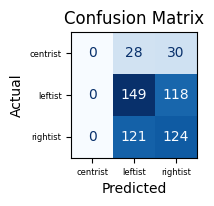

In [332]:
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred, target_names=le.classes_))

# Compact confusion matrix
cm = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(3, 2), dpi=100)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
disp.plot(ax=ax, cmap=plt.cm.Blues, colorbar=False)
ax.set(title="Confusion Matrix", xlabel="Predicted", ylabel="Actual")
ax.tick_params(axis='both', labelsize=6)
plt.tight_layout(pad=0.5)
plt.show()

Now we will check the residuals:

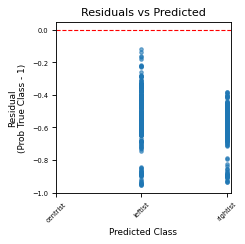

In [333]:
import numpy as np
import matplotlib.pyplot as plt

# Predict probabilities and residuals
probs = clf.predict_proba(X_test_scaled)
residuals = probs[np.arange(len(y_test)), y_test] - 1
y_pred = clf.predict(X_test_scaled)

# Create compact figure
fig, ax = plt.subplots(figsize=(3, 3), dpi=80)  # Smaller size, decent resolution
ax.scatter(y_pred, residuals, alpha=0.6, s=10)  # Smaller marker size for space
ax.set_xlabel('Predicted Class', fontsize=8)
ax.set_ylabel('Residual\n(Prob True Class - 1)', fontsize=8)
ax.set_title('Residuals vs Predicted', fontsize=10)

# Set ticks using class labels
ax.set_xticks(np.arange(len(le.classes_)))
ax.set_xticklabels(le.classes_, fontsize=6, rotation=45)
ax.tick_params(axis='y', labelsize=6)

# Reference line at 0
ax.axhline(0, color='red', linestyle='--', linewidth=1)

# Tight layout for minimal spacing
plt.tight_layout(pad=0.5)
plt.show()

| **Logistic Regression** | **Insight & Interpretation** |
| :--- | :--- |
| **1. Class Imbalance** | (1) Centrist class is underrepresented (58 vs. 267 leftist, 245 rightist). (2) Model learns majority classes only. (3) Precision/recall for centrist = 0. (4) Residuals ≈ -1 show no confidence in centrist predictions. |
| **2. Feature Relevance** | (1) Economic indicators may not differentiate centrists. (2) Centrists may resemble left/right in GDP, imports, etc. (3) Key political variables (e.g., party, elections) are missing. |
| **3. Model Limitations** | (1) Logistic regression assumes linear separability. (2) No interaction terms included. (3) May fail to capture centrist complexity. |
| **Confusion Matrix** | (1) Centrist cases mostly misclassified as leftist/rightist. (2) Model treats centrist as noise. |
| **Residual Plot** | (1) Predictions for centrist ≈ 0 probability. (2) Residuals ≈ -1 indicate model lacks confidence in centrist class. |


Below, we will fit a linear model and select Urban population as our target variable:

In [334]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import r2_score, mean_squared_error


In [335]:

#  Make a clean, independent copy of DataFrame
df_lr = df_log.copy()  # Use log-transformed DataFrame

# Define features and target ---
lr_features = [
    'leader_ideology','democracy', 'Per_capita_GNI','agriculture_and_hunting_fishing_isic','construction_isic','Imports_of_goods_and_services',
    'mining_manifacturing_isic','transport_storage_communication_isic','military_expenditure', 'GDP'
]
lr_target = 'Urban_population'

# Clean data (drop NA for X and y) ---
df_lr_clean = df_lr[lr_features + [lr_target]].dropna()

# Define X and y ---
X_lr = df_lr_clean[lr_features]
y_lr = df_lr_clean[lr_target]

# Split into train and test sets ---
X_lr_train, X_lr_test, y_lr_train, y_lr_test = train_test_split(X_lr, y_lr, test_size=0.2, random_state=42)

# Categorical and numeric features ---
lr_categorical_features = ['leader_ideology', 'democracy']
lr_numeric_features = [f for f in lr_features if f not in lr_categorical_features]

# --- MODEL 1: SCALED MODEL (Log features used) ---
preprocessor_lr_scaled = ColumnTransformer([
    ('num', StandardScaler(), lr_numeric_features),
    ('cat', OneHotEncoder(handle_unknown='ignore'), lr_categorical_features)
])

pipeline_lr_scaled = Pipeline([
    ('preprocessor', preprocessor_lr_scaled),
    ('regressor', LinearRegression())
])

pipeline_lr_scaled.fit(X_lr_train, y_lr_train)
y_lr_pred_scaled = pipeline_lr_scaled.predict(X_lr_test)

# Get feature names after scaling
lr_feature_names = pipeline_lr_scaled.named_steps['preprocessor'].get_feature_names_out()
lr_scaled_coefs = pipeline_lr_scaled.named_steps['regressor'].coef_

# --- MODEL 2: UNSCALED MODEL ---
# One-hot encode categoricals
X_lr_train_unscaled = pd.get_dummies(X_lr_train, columns=lr_categorical_features, drop_first=False)
X_lr_test_unscaled = pd.get_dummies(X_lr_test, columns=lr_categorical_features, drop_first=False)
X_lr_test_unscaled = X_lr_test_unscaled.reindex(columns=X_lr_train_unscaled.columns, fill_value=0)

lr_unscaled = LinearRegression()
lr_unscaled.fit(X_lr_train_unscaled, y_lr_train)
lr_unscaled_coefs = lr_unscaled.coef_

# Make sure the lengths match for comparison
assert len(lr_feature_names) == len(lr_unscaled_coefs), "Mismatch in feature count!"

# --- COEFFICIENT COMPARISON ---
coefficients_lr_df = pd.DataFrame({
    'Feature': lr_feature_names,
    'Coefficient_Unscaled': lr_unscaled_coefs,
    'Coefficient_Scaled': lr_scaled_coefs
}).sort_values(by='Coefficient_Unscaled', key=abs, ascending=False)

from IPython.display import display
#display(coefficients_lr_df)

# Calculate R² score and RMSE for the scaled model
r2_lr = r2_score(y_lr_test, y_lr_pred_scaled)
rmse_lr = np.sqrt(mean_squared_error(y_lr_test, y_lr_pred_scaled))

print(f"R² Score: {r2_lr:.4f}")
print(f"RMSE: {rmse_lr:.4f}")

R² Score: 0.9635
RMSE: 0.2987


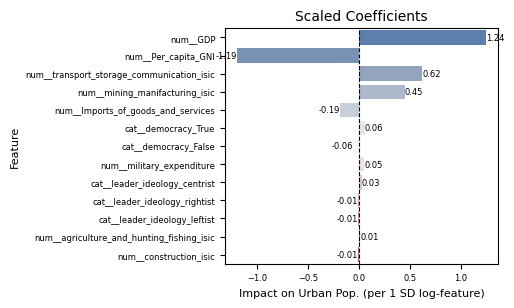

In [336]:
# Ensure proper column names
coefficients_lr_df.columns = ['Feature', 'Unscaled Coef', 'Scaled Coef']
coefficients_lr_df = coefficients_lr_df.reindex(coefficients_lr_df['Scaled Coef'].abs().sort_values(ascending=False).index)

# Compact figure
fig, ax = plt.subplots(figsize=(5, 3), dpi=100)  # Tight and high enough DPI for readability

sns.barplot(
    x='Scaled Coef',
    y='Feature',
    data=coefficients_lr_df,
    palette="vlag",
    ax=ax
)

# Minimalist title and axis labels
ax.set_title("Scaled Coefficients", fontsize=10)
ax.set_xlabel("Impact on Urban Pop. (per 1 SD log-feature)", fontsize=8)
ax.set_ylabel("Feature", fontsize=8)
ax.axvline(0, color='black', linestyle='--', linewidth=0.8)

ax.tick_params(axis='both', labelsize=6)

for i, (coef, feature) in enumerate(zip(coefficients_lr_df['Scaled Coef'], coefficients_lr_df['Feature'])):
    ax.text(
        coef,
        i,
        f'{coef:.2f}',
        va='center',
        ha='left' if coef > 0 else 'right',
        color='black',
        fontsize=6
    )

plt.tight_layout(pad=0.4)
plt.show()

| **Linear Regression** | **Interpretation on urban population** |
| :--- | :--- |
| **1. Model Performance** | (1) R² = 0.9635 → 96.35% variance in log(urban population) explained. (2) RMSE = 0.2987 → ~35% error in actual population due to log transformation. |
| **2. Top Coefficients** | (1) `GDP (+1.24)` → Strong positive driver of urban population. (2) `Per_capita_GNI (-1.19)` → Higher GNI linked to lower urban population (unexpected, warrants review). (3) `Transport/Comm. (+0.62)` → Growth in these sectors drives urbanization. (4) `Mining/Manufacturing (+0.45)` → Industrial activity boosts urban growth. (5) `Imports (-0.19)` → Possibly linked to rural import dependencies. |
| **3. Project Observations** | (1) Economic factors dominate urbanization patterns. (2) Per capita GNI effect is surprising; may involve rural bias or reverse causality. (3) Political features (ideology, democracy) show weak influence (<0.03). |


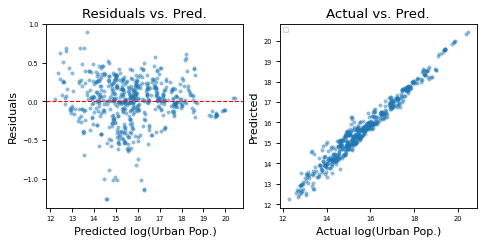

In [337]:
# Residuals
residuals_lr = y_lr_test - y_lr_pred_scaled

# Subplots
fig, axes = plt.subplots(1, 2, figsize=(6, 3), dpi=80)

# Plot 1: Residuals vs. Predicted
sns.scatterplot(x=y_lr_pred_scaled, y=residuals_lr, alpha=0.5, s=10, ax=axes[0], edgecolor=None)
axes[0].axhline(0, color='red', linestyle='--', lw=1)
axes[0].set(title="Residuals vs. Pred.", xlabel="Predicted log(Urban Pop.)", ylabel="Residuals")
axes[0].tick_params(axis='both', labelsize=6)

# Plot 2: Actual vs. Predicted
sns.scatterplot(x=y_lr_test, y=y_lr_pred_scaled, alpha=0.5, s=10, ax=axes[1], edgecolor=None)
axes[1].set(title="Actual vs. Pred.", xlabel="Actual log(Urban Pop.)", ylabel="Predicted")
axes[1].tick_params(axis='both', labelsize=6)
axes[1].legend(fontsize=6, loc='upper left')

plt.tight_layout(pad=0.5)
plt.show()

| **Diagnostic** | **Insight & Interpretation** |
| :--- | :--- |
| **Residuals vs. Predictions** | (1) Residuals mostly cluster around zero. (2) Spread increases at high predicted values → heteroscedasticity. (3) Suggests model underestimates uncertainty for large urban populations.  |
| **Actual vs. Predicted** | (1) Strong linear alignment with perfect fit line. (2) A few outliers (extreme urban populations) deviate significantly. (3) These may require closer inspection for data quality or exceptional context. |


### Partial Dependence & Interaction Effects

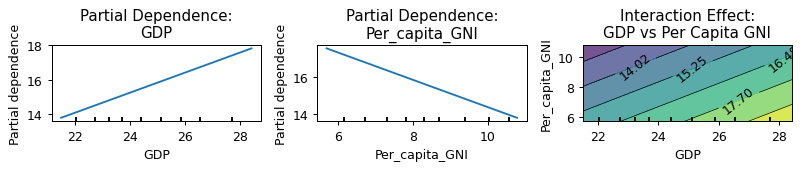

In [338]:
from sklearn.inspection import PartialDependenceDisplay
import matplotlib.pyplot as plt

features = ['GDP', 'Per_capita_GNI']
interaction = ('GDP', 'Per_capita_GNI')
fig, axes = plt.subplots(1, 3, figsize=(9, 2), dpi=90)

# Individual PDPs
for i, feat in enumerate(features):
    PartialDependenceDisplay.from_estimator(pipeline_lr_scaled, X_lr_train, [feat], ax=axes[i])
    axes[i].set_title(f"Partial Dependence:\n{feat}")

# Interaction PDP
PartialDependenceDisplay.from_estimator(pipeline_lr_scaled, X_lr_train, [interaction], ax=axes[2], kind='average', grid_resolution=30)
axes[2].set_title("Interaction Effect:\nGDP vs Per Capita GNI")

plt.tight_layout()
plt.show()

| **Partial Dependence** | **Interpretation** |
| :--- | :--- |
| **1. GDP Effect (PDP)** | (1) Strong positive linear effect on log(urban population). (2) Slope ≈ 0.5 → 1-unit increase in log(GDP) → ~0.5 log(pop) increase. (3) Doubling GDP (Δlog ≈ 0.7) → ~42% urban population increase. (4) Matches model coefficient (+1.24). |
| **2. Per_capita_GNI Effect (PDP)** | (1) Negative linear relationship. (2) Slope ≈ -0.3 → 1-unit increase in log(GNI) → ~0.3 log(pop) decrease. (3) Doubling GNI → ~19% urban population decrease. (4) Matches model coefficient (–1.19). |
| **3. GDP–GNI Interaction** | (1) Parallel PDP lines → no interaction detected. (2) Effects are additive, not multiplicative or synergistic. (3) No evidence that GDP’s effect varies by GNI or vice versa. |
| **4. Project Observations** | (1) GDP = dominant urbanization driver. (2) GNI = negative counterbalance. 

### 5.1.2 Binomial Model

**Goal**: Answer the hypothesis on binary variable democracy.

In [446]:
from statsmodels.formula.api import glm
import statsmodels.api as sm

In [447]:
df_log_new = df_log_for_binomial_model.copy().dropna()

columns_to_work_with = [
    'Per_capita_GNI', 'agriculture_and_hunting_fishing_isic', 'construction_isic', 'Imports_of_goods_and_services', 'mining_manifacturing_isic',
    'transport_storage_communication_isic', 'GDP', 'Urban_population', 'leader_ideology', 'democracy', 'military_expenditure'
]
df_log_new = df_log_new[columns_to_work_with]

***MLP Classifier must deal with the dataset of numeric types.   
So we updated the new dataframe, where for real value of string(object) type, we set a numeric equivalent for all the columns we use.***

In [448]:
%%capture

df_log_new.dtypes

In [449]:
column_mapper_dict = {}
for column in df_log_new.columns:
    if df_log_new[column].dtype == 'object':
        unique_vals = df_log_new[column].unique()
        column_mapper_dict[column] = {val: i for i, val in enumerate(unique_vals)}

        df_log_new[column] = df_log_new[column].map(column_mapper_dict[column])

In [343]:
%%capture

column_mapper_dict

In [344]:
%%capture

df_log_new.head()

We split the dataset into train and test for explanatory and target variables. Then we fit a binomial model on our target variable democracy. 

In [450]:
X_train, X_test, Y_train, Y_test = train_test_split(
    df_log_new.drop('democracy',axis=1), df_log_new['democracy'],
    test_size=0.2, random_state=1
)

In [451]:
predictors = '+'.join([col for col in X_train.columns])

binomial_glm = glm(
    f'democracy ~ {predictors}',
    data=df_log_new.loc[X_train.index],
    family=sm.families.Binomial(),
)

In [452]:
binomial_glm_res = binomial_glm.fit()

In [483]:
print(binomial_glm_res.summary2())


                          Results: Generalized linear model
Model:                     GLM                     AIC:                   1983.9801  
Link Function:             Logit                   BIC:                   -15511.7043
Dependent Variable:        democracy               Log-Likelihood:        -983.99    
Date:                      2025-05-27 01:09        LL-Null:               -1447.9    
No. Observations:          2270                    Deviance:              1968.0     
Df Model:                  7                       Pearson chi2:          1.89e+03   
Df Residuals:              2262                    Scale:                 1.0000     
Method:                    IRLS                                                      
-------------------------------------------------------------------------------------
                                      Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
--------------------------------------------------------------------------------

In [453]:
y_pred_probes = binomial_glm_res.predict(X_test)

In [454]:
y_pred = (y_pred_probes >= 0.5).astype(int)

In [455]:
cm = confusion_matrix(Y_test, y_pred)

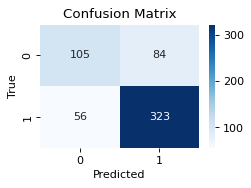

In [456]:
plt.figure(figsize=(3.2, 2), dpi=80)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

In [353]:
accuracy_score(Y_test,y_pred)

0.7535211267605634

In [354]:
print(classification_report(Y_test, y_pred))

              precision    recall  f1-score   support

           0       0.65      0.56      0.60       189
           1       0.79      0.85      0.82       379

    accuracy                           0.75       568
   macro avg       0.72      0.70      0.71       568
weighted avg       0.75      0.75      0.75       568



***Let's drop couple of features which are not significant, and few which can potentially cause collinearity. The dropped non significant columns are agriculture, construction and leader ideology.
and build an updated model***

In [457]:
non_significant_columns_per_p = ['agriculture_and_hunting_fishing_isic', 'construction_isic', 'leader_ideology']
X_reduce_train = X_train.drop(columns=non_significant_columns_per_p)
predictors = '+'.join([col for col in X_reduce_train.columns])

binomial_gam = glm(
    f'democracy ~ {predictors}',
    data=df_log_new.drop(columns=non_significant_columns_per_p).loc[X_reduce_train.index],
    family=sm.families.Binomial(),
)

In [458]:
binomial_glm_res = binomial_gam.fit()

In [459]:
binomial_glm_res.summary()
from IPython.display import HTML, display
display(HTML(f"<pre style='font-size:12px'>{binomial_glm_res}</pre>"))

In [460]:
np.exp(binomial_glm_res.params['Per_capita_GNI'])

6.904179745692617

In [461]:
np.exp(binomial_glm_res.params['military_expenditure'])

0.20603402411105345

| **Interpretation** |  |
| :--- | :--- |
| **Model Significance** | All selected features are now statistically significant, improving the credibility of the model. |
| **Model Fit (Pseudo R² - CS)** | The model explains approximately 33% of the variation in the target (democracy), indicating a moderate fit. |
| **Interpretation Note** | In binary logistic models, coefficients are in log-odds. To interpret them meaningfully, we apply the exponential function to get **odds ratios**. |
| **Per_capita_GNI (largest coefficient)** | A one-unit increase in `Per_capita_GNI` leads to nearly **7× increase** in the odds of a country being democratic (holding other features constant). |
| **Military_expenditure (inverse effect)** | A one-unit increase in `military_expenditure` corresponds to a **21% decrease** in the odds of democracy. |
| **Interpretation Rule** | Beyond these, the interpretation of other coefficients follows the same odds-ratio logic. |
| **Next Step** | A visual plot of feature coefficients will be built to illustrate the direction and magnitude of each feature’s effect. |


In [462]:
# Prepare odds ratios and CIs
coefs = binomial_glm_res.params.drop('Intercept')
conf = binomial_glm_res.conf_int().drop('Intercept')
or_df = pd.DataFrame({
    'OR': np.exp(coefs),
    '2.5%': np.exp(conf[0]),
    '97.5%': np.exp(conf[1])
}).sort_values(by='OR', ascending=False)



***Evaluate model performance***

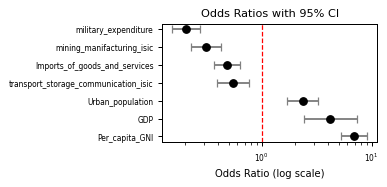

In [463]:
# Plot
plt.figure(figsize=(4.2, 2), dpi=90)
plt.errorbar(or_df['OR'], or_df.index,
             xerr=[or_df['OR'] - or_df['2.5%'], or_df['97.5%'] - or_df['OR']],
             fmt='o', color='black', ecolor='gray', capsize=3)
plt.axvline(1, color='red', linestyle='--', lw=1)
plt.xlabel("Odds Ratio (log scale)", fontsize=8)
plt.title("Odds Ratios with 95% CI", fontsize=9)
plt.xscale('log')
plt.xticks(fontsize=6); plt.yticks(fontsize=6)
plt.tight_layout(pad=0.4)
plt.show()

In [464]:
y_pred_probes = binomial_glm_res.predict(X_test.drop(columns=non_significant_columns_per_p))

In [465]:
y_pred = (y_pred_probes >= 0.5).astype(int)

In [466]:
cm = confusion_matrix(Y_test, y_pred)

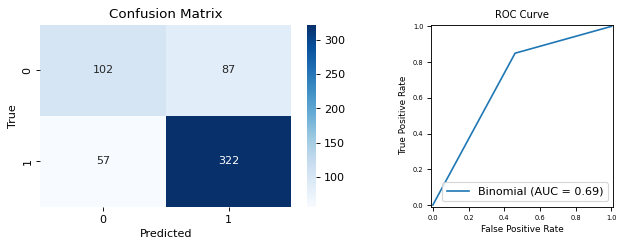

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc, RocCurveDisplay


fpr, tpr, thresholds = roc_curve(Y_test, y_pred)
auci = auc(fpr, tpr)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8.5, 3), dpi=80)  # Wide figure with 2 axes

# Plot 1: Confusion Matrix Heatmap on ax1
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", ax=ax1)
ax1.set_title("Confusion Matrix")
ax1.set_xlabel("Predicted")
ax1.set_ylabel("True")

# Plot 2: ROC Curve on ax2
RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=auci, estimator_name='Binomial').plot(ax=ax2)
ax2.set_title("ROC Curve", fontsize=9)
ax2.set_xlabel("False Positive Rate", fontsize=8)
ax2.set_ylabel("True Positive Rate", fontsize=8)
ax2.tick_params(labelsize=6)

plt.tight_layout(pad=0.4)
plt.show()


In [366]:
accuracy_score(Y_test, y_pred)

0.7464788732394366

In [367]:
print(classification_report(Y_test, y_pred))

              precision    recall  f1-score   support

           0       0.64      0.54      0.59       189
           1       0.79      0.85      0.82       379

    accuracy                           0.75       568
   macro avg       0.71      0.69      0.70       568
weighted avg       0.74      0.75      0.74       568



***From the above results, we have confirmed that the model has quite good performance.  
In term of simplicity of the model and clear understanding of how features influence the response variable, 
it might be a good choice to use, if there's not such a goal to have as high accuracy as possible***

### 5.1.3 Poisson Model:

**Goal**: To answer the count hypothesis on Urban population.

**Setup**: The data is split into train and test dataset, keeping the variables of interest as explanatory features and our target variable Y as Urban population.

           1- Quasi-poisson Model

           2- Negative binomial Model

**Results**: Pseudo R2 (NB Model):~ 0.68, RMSE (NB Model):~ 10158405

There is overdispersion so quasipoisson model is a better fit:

In [370]:
# Train-Test Split
df_log['Urban_population'] = np.exp(df_log['Urban_population'])

#print(df_log['Urban_population'] )

X_train, X_test, y_train, y_test = train_test_split(
    df_log.drop(columns='Urban_population'),  # predictors
    df_log['Urban_population'],               # target
    test_size=0.2,                            # 20% test data
    random_state=42                           # for reproducibility
)





In [371]:
# Recombine X and y into one training DataFrame
train_data = X_train.copy()
train_data['Urban_population'] = y_train
#print(train_data)




In [372]:
from IPython.display import HTML, display


In [373]:
formula = 'Urban_population ~ leader_ideology + democracy  + Per_capita_GNI + agriculture_and_hunting_fishing_isic +construction_isic  + Imports_of_goods_and_services + mining_manifacturing_isic + transport_storage_communication_isic  + military_expenditure + GDP'
qp_model = smf.glm(formula=formula, data=train_data, family=sm.families.Poisson()).fit(scale='dev')  # 'X2' enables quasi-poisson estimation

In [374]:
summary=qp_model.summary()
display(HTML(f"<pre style='font-size:10px'>{summary}</pre>"))

| Variable                                | Effect (exp(Coeff)) | Interpretation                                                                                          | Significance (P-value) |
|----------------------------------------|---------------------|------------------------------------------------------------------------------------------------------|-----------------------|
| **Intercept**                          | 0.2672              | Baseline expected urban population when all predictors are at reference levels (no democracy, etc.)  | —                     |
| **Leader Ideology (rightist)**         | 0.9755              | ~2.45% lower urban population with rightists vs. centrist/leftist leaders                                           | 0.031 (significant)   |
| **Democracy**                         | 1.0553              | ~5.53% higher urban population in democracies                                                        | 0.000 (significant)   |
| **Per Capita GNI**                    | 0.4875              | ~51.25% decrease per unit increase; wealthier countries tend to have lower urban population growth        | 0.000 (significant)   |
| **Construction Sector**               | 0.9701              | ~2.99% lower urban population per unit increase in construction, small but significant effect                                     | 0.014 (significant)   |
| **Imports of Goods and Services**    | 0.8546              | ~14.54% decrease per unit increase; higher imports linked to lower urban population growth          | 0.000 (significant)   |
| **Mining and Manufacturing Sector**  | 1.2773              | ~27.73% increase per unit increase; positive relationship with urban population growth               | 0.000 (significant)   |
| **Military Expenditure**              | 0.9575              | ~4.25% decrease per unit increase; significant negative effect                                       | 0.000 (significant)   |
| **GDP**                              | 2.4940              | ~149.40% increase per unit increase; strong positive link to urban population growth                 | 0.000 (significant)   |
| **Leader Ideology (leftist)**         | 0.9929              | Small effect; statistically not significant                                                     | 0.557 (not significant)|
| **Agriculture, Hunting, and Fishing** | 0.9857              | No significant impact on urban population growth                                                     | 0.130 (not significant)|
| **Transport, Storage, and Communication** | 0.9808          | Small, non-significant effect                                                                        | 0.281 (not significant)|

---

### Summary

Urban population growth is more pronounced in wealthier countries (higher GDP) and those with more mining/manufacturing activity. Democracies tend to have slightly larger urban populations. Conversely, higher military spending, right wing leaders and imports correlate with reduced urban population growth. Agriculture, and interestingly transport seem to not have a meaningful relationship with Urban population.


Now we will check the residual plots:

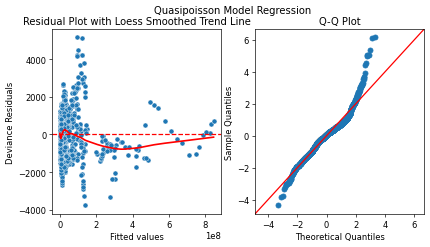

In [375]:
# Deviance residuals
deviance_residuals = qp_model.resid_deviance

# Plotting
fig, ax = plt.subplots(1, 2, figsize=(8, 4),dpi=60)
plt.suptitle('Quasipoisson Model Regression')

# Residual plot
sns.scatterplot(x=qp_model.fittedvalues, y=deviance_residuals, ax=ax[0])

# Add a smoothed trend line
try:
    loess = sm.nonparametric.lowess(deviance_residuals, qp_model.fittedvalues, frac=0.6)
    ax[0].plot(loess[:, 0], loess[:, 1], color='red', linewidth=2)
except Exception as e:
    print(f"Could not create LOWESS line: {e}")

ax[0].axhline(0, color='red', linestyle='--')
ax[0].set_xlabel('Fitted values')
ax[0].set_ylabel('Deviance Residuals')
ax[0].set_title('Residual Plot with Loess Smoothed Trend Line')

# Q-Q Plot
sm.qqplot(deviance_residuals, line='45', fit=True, ax=ax[1])
ax[1].set_xlabel('Theoretical Quantiles')
ax[1].set_ylabel('Sample Quantiles')
ax[1].set_title('Q-Q Plot')

plt.show()

The residual plots show overdispersion and heteroscedasticity. Negative binomial might be a better approach. For the Negative binomial Model, alpha is calculated using MLE method from quasipoisson model using R (alpha value comes from there).

In [376]:
formula = 'Urban_population ~ leader_ideology + democracy  + Per_capita_GNI + agriculture_and_hunting_fishing_isic +construction_isic  + Imports_of_goods_and_services + mining_manifacturing_isic + transport_storage_communication_isic  + military_expenditure + GDP '

model_nb = smf.glm(
    formula=formula,
    data=train_data,
    family=sm.families.NegativeBinomial(alpha=2.43)
).fit()

result_nb = model_nb


In [377]:
summary=result_nb.summary()
from IPython.display import HTML, display
display(HTML(f"<pre style='font-size:10px'>{summary}</pre>"))

| Variable                                | Coefficient (exp)         | Interpretation                                                                                                                                          | Significant (P-value) |
|-----------------------------------------|----------------------------|----------------------------------------------------------------------------------------------------------------------------------------------------------|------------------------|
| **Intercept**                           | exp(-0.9069) = 0.4049      | The baseline expected urban population.                                                                                                                 | No (0.219)             |
| **Per Capita GNI**                      | exp(-0.7498) = 0.4721      | A 1-unit increase is associated with a 52.79% decrease in expected urban population. Wealthier countries tend to have lower urban population growth.     | **0.000(significant)**        |
| **Mining & Manufacturing Sector**       | exp(0.1836) = 1.2012       | A 1-unit increase is associated with a 20.12% increase in expected urban population. Suggests mining activity drives higher urban growth.                  | **0.041 (significant)**        |
| **Transport, Storage & Communication**  | exp(0.2557) = 1.2912       | A 1-unit increase is associated with a 29.12% increase in expected urban population. Indicates more investment in transport leads to greater urban population growth.    | **0.017 (significant)**        |
| **GDP**                                 | exp(0.6225) = 1.8647       | A 1-unit increase is associated with an 86.47% increase in expected urban population. Wealthier countries tend to have larger urban populations.          | **0.002 (significant)**        |
| **Leader Ideology (Leftist)**           | exp(-0.0432) = 0.9574      |  No substantial evidence that leftist leadership affects urban population growth.                                          | 0.703(not significant)             |
| **Leader Ideology (Rightist)**          | exp(-0.0535) = 0.9477      | No substantial evidence that rightist leadership affects urban population growth.                                         | 0.640 (not significant)             |
| **Democracy**                           | exp(0.0948) = 1.0995       |  Democracies do not show a strong effect on urban population compared to non-democracies.                                  | 0.26(not significant)             |
| **Agriculture, Hunting & Fishing**      | exp(0.0002) = 1.0002       | Agriculture sector has no meaningful impact on urban population growth.                                                          | 0.998 (not significant)            |
| **Construction Sector**                 | exp(-0.0017) = 0.9983      |  Construction sector does not meaningfully relate to urban population growth in the model.                                         | 0.982 (not significant)            |
| **Imports of Goods and Services**       | exp(-0.1053) = 0.8994      | No clear evidence that imports are linked to changes in urban population growth.                                          | 0.222 (not significant)             |
| **Military Expenditure**                | exp(0.1170) = 1.1238       | Though the effect is positive, it does not have a strong relationship with urban population growth.                       | 0.189 (not significant)            |

Wealthier countries, particularly those with higher GDP, tend to have larger urban populations, though higher per capita GNI relate to slower urban growth. This might mean that, richer the individuals, they prefer to live in the countryside rather than in the cities even though the country is more developed. Significant increases in urban population are observed in countries with more activity in the mining, manufacturing, and transport sectors which is inline with research from Rickardsson (2021). Political leadership, democracies and sectors like agriculture, construction, imports, and military spending do not show strong or significant effects.



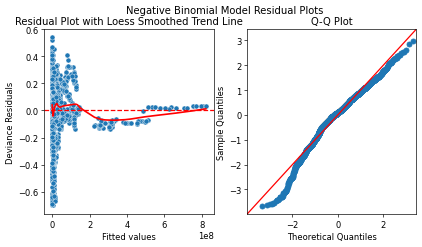

In [378]:
# Deviance residuals
deviance_residuals = model_nb.resid_deviance

# Plotting
fig, ax = plt.subplots(1, 2, figsize=(8, 4),dpi=60)
plt.suptitle('Negative Binomial Model Residual Plots')

# Residual plot
sns.scatterplot(x=model_nb.fittedvalues, y=deviance_residuals, ax=ax[0])

# Add a smoothed trend line
try:
    loess = sm.nonparametric.lowess(deviance_residuals, model_nb.fittedvalues, frac=0.6)
    ax[0].plot(loess[:, 0], loess[:, 1], color='red', linewidth=2)
except Exception as e:
    print(f"Could not create LOWESS line: {e}")

ax[0].axhline(0, color='red', linestyle='--')
ax[0].set_xlabel('Fitted values')
ax[0].set_ylabel('Deviance Residuals')
ax[0].set_title('Residual Plot with Loess Smoothed Trend Line')

# Q-Q Plot
sm.qqplot(deviance_residuals, line='45', fit=True, ax=ax[1])
ax[1].set_xlabel('Theoretical Quantiles')
ax[1].set_ylabel('Sample Quantiles')
ax[1].set_title('Q-Q Plot')

plt.show()

Negative binomial model seems to be a better fit. QQplot is close to being flat while still having some irregularities in left tail and fitted vs residuals dispersed randomly around 0 (Fitted value scale is 1e8)

RMSE: 10158405.7124


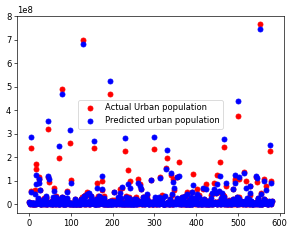

In [379]:
y_pred = model_nb.predict(X_test)

plt.figure(figsize=(5, 4), dpi=60)
plt.scatter(range(len(y_test)), y_test, color='red')
plt.scatter(range(len(y_pred)), y_pred, color='blue')
plt.legend(['Actual Urban population', 'Predicted urban population'])
plt.tight_layout()

y_test_numeric = pd.to_numeric(y_test, errors='coerce')
y_pred_numeric = pd.to_numeric(y_pred, errors='coerce')

# Drop rows where either is NaN
valid_indices = (~y_test_numeric.isna()) & (~y_pred_numeric.isna())

# Filter only valid rows
y_test_clean = y_test_numeric[valid_indices]
y_pred_clean = y_pred_numeric[valid_indices]

# Now compute RMSE
from sklearn.metrics import mean_squared_error

rmse= np.sqrt(mean_squared_error(y_test_clean, y_pred_clean))
print(f"RMSE: {rmse:.4f}")

The predicted vs actual values seem to correspond to each other in our visual check while being slightly off. RMSE seems quite high but we are in 1e8 range so looks reasonable.

## 5.2 Generalized Additive Models

**Goal:** To answer the continuous hypothesis on military expenditure.

For GAM's we first tried to use pyGAM package. However, this package does not use maximum likelihood methods and p-values should be approached with caution. Below there is the snippet of python approach. To be able to interpret our results we used R's mgcv package with the same model and imported the results to this jupyter notebook. We will interpret the results from R that used REML method.


**Setup:**
The data was split to train and test, military expenditure being the target variable. Then first we fit a quadratic polynomial model, after a Python pyGAM model, and finally we fit the GAM's using R's mgcv package. Following residual checks, we did a Yeo-Johnson transformation on the target variable and fit again GAM in mgcv in R.

**Results:**  
R2-adjusted (Yeo-Johnson transformed GAM): 0.352 , RMSE (Yeo-Johnson transformed GAM): 0.3306554


In [380]:
selected_cols = ['Per_capita_GNI', 'agriculture_and_hunting_fishing_isic', 'construction_isic','transport_storage_communication_isic', 'Imports_of_goods_and_services', 'mining_manifacturing_isic', 'GDP', 'military_expenditure', 'Urban_population']
df_log_a=df_log.copy().dropna(subset=['Urban_population'])

X_train, X_test, y_train, y_test = train_test_split(
    df_log_a.drop(columns='military_expenditure'),  # predictors
    df_log_a['military_expenditure'],               # target
    test_size=0.2,                            # 20% test data
    random_state=42                           # for reproducibility
)
# Recombine X and y into one training DataFrame
train_data = X_train.copy()
train_data['military_expenditure'] = y_train
#print(train_data)

First, we fit a quadratic polynomial model. We hypothesize that some of the variables with military_expenditure can have a non-linear relationship regarding their distributions we plotted in the EDA.

In [381]:
# Map variable names to column indices in X_train
name_to_idx = {name: i for i, name in enumerate(X_train.columns)}

model = smf.ols(formula='''
military_expenditure ~ leader_ideology + democracy
+ Per_capita_GNI +
+ I(agriculture_and_hunting_fishing_isic*2)
+ I(construction_isic*2)
+ I(Imports_of_goods_and_services*2)
+ I(mining_manifacturing_isic*2)
+ Urban_population
+ I(GDP*2)
''', data=train_data).fit()

In [382]:
summary=model.summary()
from IPython.display import HTML, display
display(HTML(f"<pre style='font-size:10px'>{summary}</pre>"))

In the quadratic model democracy,GNI,agriculture,imports,GDP and urban population are significant. Rsquared is low.  We would like to fit a GAM model for better adjustments for non linearities.

We need to have all the variables values in float or int format for pyGAM. We achieve this by using one hot encoding. However, since pyGAM does not use maximum likelihood method and the p values should be interpreted with caution even though we run the analysis, we show here only the results from R mgcv package. If you are interested in pyGAM results, you can look at the jupyter notebook for further information.

In [383]:
df_log_b=df_log.copy().dropna(subset=['Urban_population'])
cols = [
    'Per_capita_GNI', 'agriculture_and_hunting_fishing_isic', 'construction_isic', 'Imports_of_goods_and_services', 'mining_manifacturing_isic',
    'transport_storage_communication_isic', 'GDP', 'Urban_population', 'leader_ideology', 'democracy']
# Split data
X_train, X_test, y_train, y_test = train_test_split(
    df_log_b.drop(columns='military_expenditure'),
    df_log_b['military_expenditure'],
    test_size=0.2,
    random_state=42
)
X_train_sel = X_train[cols].copy()
X_test_sel = X_test[cols].copy()

X_train_sel['Urban_population_log'] = np.log1p(X_train_sel['Urban_population'])
X_test_sel['Urban_population_log'] = np.log1p(X_test_sel['Urban_population'])

X_train_sel = X_train_sel.drop(columns=['Urban_population'])
X_test_sel = X_test_sel.drop(columns=['Urban_population'])

# One-hot encode categorical columns on train
X_train_encoded = pd.get_dummies(    X_train_sel, columns=['leader_ideology', 'democracy'], drop_first=True, dtype=int )

# One-hot encode categorical columns on test
X_test_encoded = pd.get_dummies( X_test_sel, columns=['leader_ideology', 'democracy'], drop_first=True, dtype=int )

X_test_encoded = X_test_encoded.reindex(columns=X_train_encoded.columns, fill_value=0)

# Replace infinite values with NaN y
X_train_encoded.replace([np.inf, -np.inf], np.nan, inplace=True)
X_test_encoded.replace([np.inf, -np.inf], np.nan, inplace=True)

# Drop rows with NaN in X_train and adjust y_train accordingly
train_mask = X_train_encoded.notnull().all(axis=1)
X_train_encoded = X_train_encoded.loc[train_mask]
y_train = y_train.loc[X_train_encoded.index]

test_mask = X_test_encoded.notnull().all(axis=1)
X_test_encoded = X_test_encoded.loc[test_mask]
y_test = y_test.loc[X_test_encoded.index]

#print(f"Training shape: X={X_train_encoded.shape}, y={y_train.shape}")
#print(f"Test shape: X={X_test_encoded.shape}, y={y_test.shape}")

#X_train_encoded.to_csv('X_enc.csv', index=False)  # Save X DataFrame to a CSV file (no row indices)
#y_train.to_csv('y_train_enc.csv', index=False)  # Save y_train to a CSV file (no row indices)
#y_test.to_csv('y_test_enc.csv', index=False)  # Save y_train to a CSV file (no row indices)
#X_test_encoded.to_csv('x_test_enc.csv', index=False)  # Save y_train to a CSV file (no row indices)

In [384]:
%%capture
#-------------delete %%capture if you want to see results of pygam--------------

from pygam import LinearGAM, s, f

gam = LinearGAM(s(0)+s(1)+s(2)+s(3)+s(4)+s(5)+s(6)+s(7)+f(8)+f(9)).fit(X_train_encoded.values, y_train)
#gam.gridsearch(X.values, y)

import io
from contextlib import redirect_stdout
from IPython.display import HTML, display

buf = io.StringIO()
with redirect_stdout(buf):
    gam.summary()
summary_text = buf.getvalue()

display(HTML(f"<pre style='font-size:12px'>{summary_text}</pre>"))

gam.deviance_residuals(X_train_encoded, y_train)
# 1. Residuals plot
plt.figure(figsize=(6, 3),dpi=70)
plt.subplot(1, 2, 1)
plt.scatter(gam.predict(X_train_encoded), gam.deviance_residuals(X_train_encoded, y_train), alpha=0.3)
plt.axhline(0, color='r', ls='--')
plt.xlabel("Predicted values")
plt.ylabel("Deviance residuals")
plt.title("Residuals vs Fitted")

# 2. QQ plot
plt.subplot(1, 2, 2)
from scipy.stats import probplot
probplot(gam.deviance_residuals(X_train_encoded, y_train), dist="norm", plot=plt)
plt.title("QQ Plot of Residuals")
plt.tight_layout()

In [385]:
with open("gam_R/gam_model_summary.txt", "r") as f:
    summary_text = f.read()

print("=== GAM Model Summary ===")
summary=summary_text
from IPython.display import HTML, display
display(HTML(f"<pre style='font-size:8px'>{summary}</pre>"))

=== GAM Model Summary ===



 **Intercept** is significant and ~1. This shows a ~3 % of GDP is a baseline value for military expenditure when holding all the predictors at 0.

 ***Continuous predictors:***

 - All smooth terms are significant and their degrees of freedom are different than 1. This indicates important nonlinear relationships exist with the response variable. Economic indicators have significant non-linear relationships with military expenditure. s(Per_capita_GNI) is the most complex smooth term with the highest degrees of freedom.

***Categorical predictors (parametric terms):***

- Rightist leader ideology is not significant. Being rightist does not significantly affect the outcome.
Having a democracy is significant. Democracies tend to have lower values of military expenditure which is in line with the previous research and our hypothesis.
Leftist leader ideology is not significant as well. Leader ideologies does not seem to have an effect on military expenditure.


- Overall, the model explains ~34.6% of the variability in the data which is not a lot but could be considered okay for social sciences.
Below we check grid plots for each of our variables, to see if they really follow a non-linear relationship with the response variable.


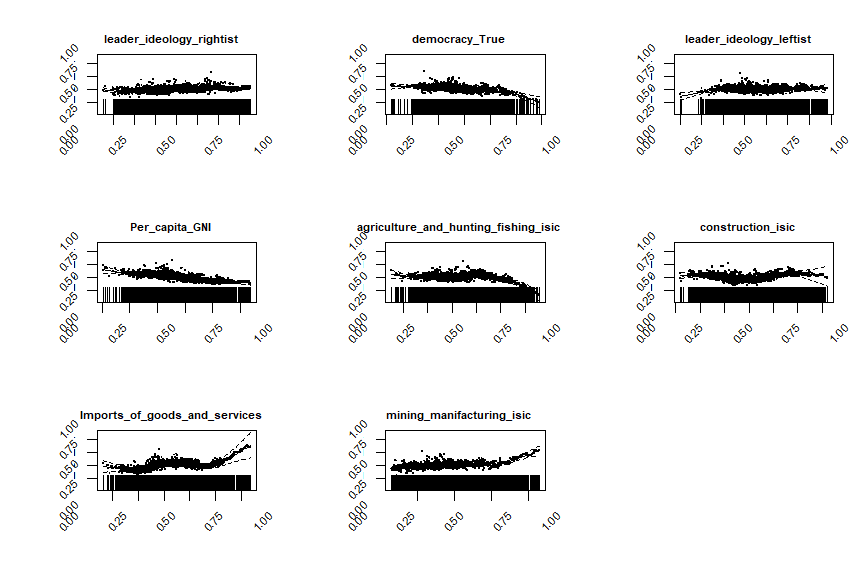

In [386]:
from IPython.display import Image, display

# Make sure the path is correct
display(Image(filename="gam_R/grid_plot.png",width=600,height=500))

In the graphs, we clearly see that except the first variable, all the variables follow a non-linear relationship and it is captured by our model. However, we also see that variance is higher for couple of variables for higher values.
Now we will check diagnostics for our GAM model:


In [387]:
with open("gam_R/gam_check_output.txt", "r") as f:
    check_text = f.read()

print("=== GAM Check Diagnostics ===")

summary=check_text
from IPython.display import HTML, display
display(HTML(f"<pre style='font-size:8px'>{summary}</pre>"))

print("RMSE:0.3275406")

=== GAM Check Diagnostics ===


RMSE:0.3275406


The model is stable and most of the terms are fitted well (p values are not significant in model check).

- Urban population has a significant k index, which suggests that it might be under smoothed. It might be better to not infer on the results of this variable.

- The diagnostics shows that the relationships are non-linear for our variables with the response variable, that are well fitted with smooth terms.

- The model root mean squared error is 0.327. On average, the model’s predictions are off by about 32.7% of the mean value of the target variable.


Now let's check the residuals:


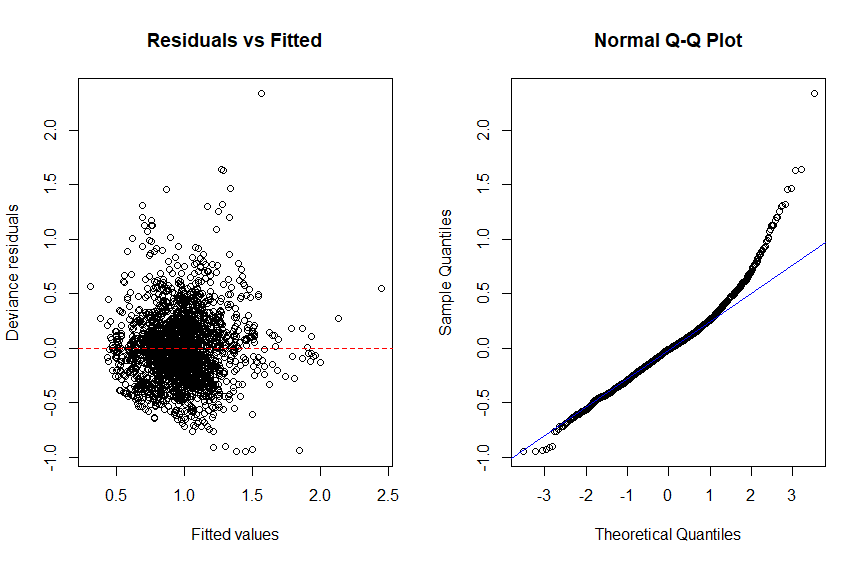

In [442]:
from IPython.display import Image, display

display(Image(filename="gam_R/RESIDUAL_DIAG.png",width=300, height=300))

Residual vs fitted does not show any pattern and is flat. Variablity of residuals seems to be constant. However, we see a right tailed qqplot. Right-skewed residuals suggests that the model is underestimating the values on the higher end of the response variable. In other words, the residuals (which represent the difference between the predicted and actual values) are often negative for smaller actual values, but they tend to become positive as the actual values increase. For this we try to transform our response variable with: Yeo-Johnson method.

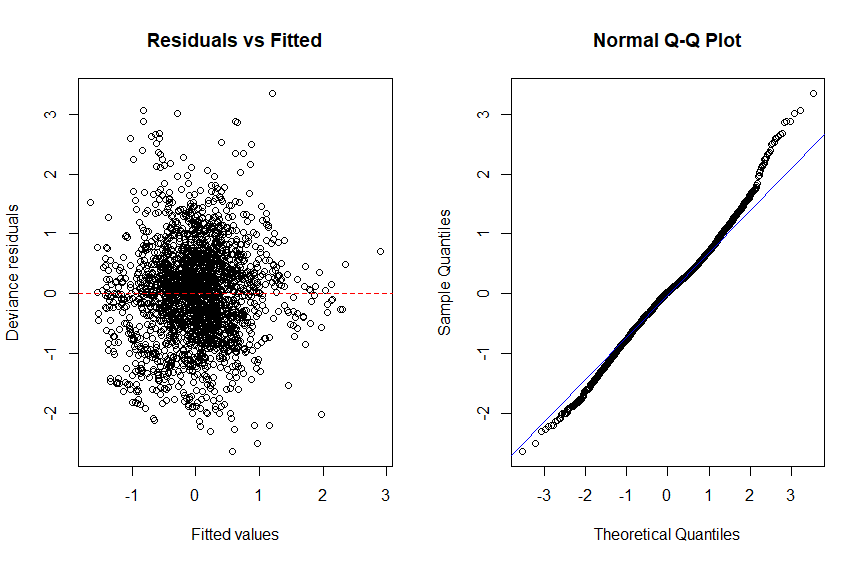

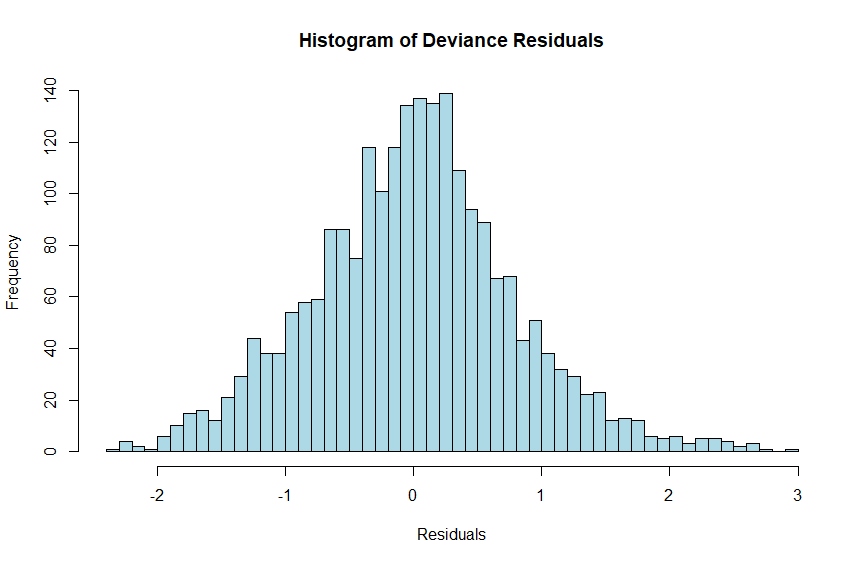

In [444]:

display(Image(filename="gam_R/YEOJOHNSONTRANSFORMED.png",width=300, height=300))
display(Image(filename="gam_R/yeojohnson_histogram.png",width=300, height=300))

After the Yeo-Johnson transformation, our residuals seem to be improved. The distribution of residuals looks more normal and there are less deviations in the right end in the qqplot.
Below we check again the model diagnostics to see if anything changed after transforming the response variable:

In [390]:
with open("gam_R/YEOJOHNSON_model_summary.txt", "r") as f:
    check_text = f.read()

print("=== GAM Summmary Yeo Johnson ===")
summary= check_text
from IPython.display import HTML, display
display(HTML(f"<pre style='font-size:8px'>{summary}</pre>"))

print("RMSE:0.3306554")

=== GAM Summmary Yeo Johnson ===


RMSE:0.3306554


**The variables that have significant relationships with military expenditure has not changed. In addition, having a leftist ideology significantly relates to lower military spending in this model. The residuals are looking slightly better and R squared (%35.2) is slightly improved with yeo-johnson transformation however model performs slightly worse than before with %33 prediction errors of the mean value of target variable . We can say that there are other factors that affect military spending which we did not address in our model.**

## 5.3 Neural Networks

**Neural Network**:

In [434]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPRegressor, MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.model_selection import GridSearchCV

#### Classification (multi-label)
  We will predict leader_ideology from the features we have by splitting dataset into train and test , leader ideology being our target variable.

In [432]:
X_train, X_test, Y_train, Y_test = train_test_split(
    df_log_new.drop('leader_ideology',axis=1), df_log_new['leader_ideology'],
    test_size=0.2, random_state=1
)

| **Interpretation**                              |                                                                                                                                                                       |
|----------------------------------------|----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| **Feature Scaling**                    | MLP is very sensitive to feature scaling; using the same scaling method across features is recommended. StandardScaler is a common choice.                                     |
| **Outliers and Scaling**              | Outliers can negatively impact scaling, leading to distorted results.                                                                                                           |
| **MLP Parameters**                     |                                                                                                                                                                                  |
| `solver`                               | Optimization algorithm. `LBFGS` is effective for small datasets and suitable here.                                                                                               |
| `alpha`                                | Regularization parameter to control overfitting and bias.                                                                                                                       |
| **Effect of `alpha`**                  | - Increasing alpha → smaller weights → simpler decision boundaries → may reduce overfitting. <br> - Decreasing alpha → larger weights → more complex boundaries → may fix bias. |


***Now, lets build MLP Classifier with different hidden_layer_num parameter from 10 to 1500 with step 100, 
and check, will there be a benefit of using higher hidden_layer_num***

In [435]:
hidden_layer_num_accuracy_dict = {}
for hidden_layer_num in range(10,1500,100):
    pipeline = Pipeline(steps=[
    ("preprocessor", StandardScaler()),
    ("classifier", MLPClassifier(
        solver='lbfgs',
        alpha=1e-5,
        hidden_layer_sizes=(hidden_layer_num,),
        random_state=1
        )
        )
    ])

    pipeline.fit(X_train, Y_train)

    y_pred = pipeline.predict(X_test)
    accuracy = accuracy_score(Y_test, y_pred)

    hidden_layer_num_accuracy_dict[hidden_layer_num] = accuracy

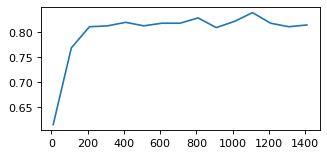

In [436]:
plt.figure(figsize=(4.5, 2), dpi=80)
plt.tight_layout(pad=0.4)
plt.plot(hidden_layer_num_accuracy_dict.keys(), hidden_layer_num_accuracy_dict.values())

**Interpretation:** According to the above plot, we can say, that there's no any clear sign, that higher hidden_layer_num is better in our concrete case after reaching num_layers=200

***Next, let's build an MLPClassifier model with some basic configuration, 
train it on a subset of data, predict results and calculate accuracy and other model evaluation criterias***

In [437]:
pipeline = Pipeline(steps=[
("preprocessor", StandardScaler()),
("classifier", MLPClassifier(
    solver='lbfgs',
    alpha=1e-5,
    hidden_layer_sizes=(200,),
    random_state=1
    )
    )
])

pipeline.fit(X_train, Y_train)

y_pred = pipeline.predict(X_test)

print(f"Accuracy: {accuracy_score(Y_test, y_pred):.4f}")

Accuracy: 0.7975


***The Accuracy looks to be good***

In [438]:
print(classification_report(Y_test, y_pred))

              precision    recall  f1-score   support

           0       0.84      0.83      0.84       266
           1       0.77      0.79      0.78       238
           2       0.74      0.66      0.69        64

    accuracy                           0.80       568
   macro avg       0.78      0.76      0.77       568
weighted avg       0.80      0.80      0.80       568



***By checking classification report, the results look very good. Precision and recall have very high values***

In [439]:
cm = confusion_matrix(y_pred, Y_test)

In [440]:
cm

array([[222,  38,   5],
       [ 40, 189,  17],
       [  4,  11,  42]], dtype=int64)

In [399]:
import seaborn as sns

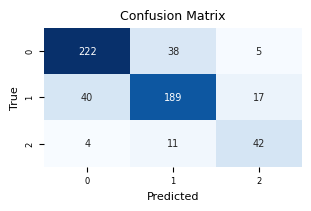

In [441]:
plt.figure(figsize=(3, 2), dpi=100)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False, annot_kws={"size":7})
plt.title("Confusion Matrix", fontsize=9)
plt.xlabel("Predicted", fontsize=8)
plt.ylabel("True", fontsize=8)
plt.xticks(fontsize=6); plt.yticks(fontsize=6)
plt.tight_layout(pad=0.3)
plt.show()

***We have a very high accuracy on predicting ideology from the features we include***

#### Classification (binary)
Now we will predict democracy from the features we have, splitting dataset to train and test, our target being democracy.

In [468]:
X_train, X_test, Y_train, Y_test = train_test_split(
    df_log_new.drop('democracy',axis=1), df_log_new['democracy'],
    test_size=0.2, random_state=1
)

In [469]:
pipeline = Pipeline(steps=[
("preprocessor", StandardScaler()),
("regressor", MLPClassifier(
    solver='lbfgs',
    alpha=1e-5,
    hidden_layer_sizes=(200,),
    random_state=1
    )
    )
])

pipeline.fit(X_train, Y_train)

y_pred = pipeline.predict(X_test)

In [470]:
print(f"Accuracy: {accuracy_score(Y_test, y_pred):.4f}")

Accuracy: 0.9366


In [471]:
cm = confusion_matrix(Y_test, y_pred)

In [406]:
print(classification_report(Y_test, y_pred))

              precision    recall  f1-score   support

           0       0.88      0.94      0.91       189
           1       0.97      0.94      0.95       379

    accuracy                           0.94       568
   macro avg       0.92      0.94      0.93       568
weighted avg       0.94      0.94      0.94       568



In [407]:
roc_auc_score(Y_test, y_pred)

0.9365916991246807

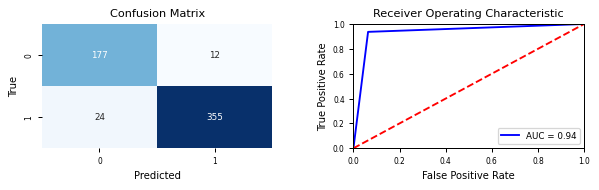

In [477]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc


fpr, tpr, threshold = roc_curve(Y_test, y_pred)
roc_auc = auc(fpr, tpr)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6.5, 2), dpi=90)  # Side by side, width adjusted

# Left: Confusion Matrix heatmap
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False, annot_kws={"size":7}, ax=ax1)
ax1.set_title("Confusion Matrix", fontsize=9)
ax1.set_xlabel("Predicted", fontsize=8)
ax1.set_ylabel("True", fontsize=8)
ax1.tick_params(axis='x', labelsize=6)
ax1.tick_params(axis='y', labelsize=6)

# Right: ROC curve
ax2.plot(fpr, tpr, 'b', label='AUC = %0.2f' % roc_auc)
ax2.plot([0, 1], [0, 1], 'r--')
ax2.set_xlim([0, 1])
ax2.set_ylim([0, 1])
ax2.set_title('Receiver Operating Characteristic', fontsize=9)
ax2.set_xlabel('False Positive Rate', fontsize=8)
ax2.set_ylabel('True Positive Rate', fontsize=8)
ax2.legend(loc='lower right', fontsize=7)
ax2.tick_params(labelsize=6)
fig.subplots_adjust(wspace=30)
plt.tight_layout(pad=0.3)
plt.show()


***By checking Accuracy, classification report, confusion matrix and ROC plot, we can come with a conclusion,
that model actually performs quite well to predict the binomial feature - democracy***

### Neural network Regression for Military Expenditure
- **Goal**: Predict a country’s military spending from our log-transformed economic and demographic features.  
- **Setup**:  
  - Pipeline with a `StandardScaler` and an `MLPRegressor`  
  - One hidden layer of 200 neurons, solver = `lbfgs`, regularization α = 1e-5  
  - All inputs and the target (`military_expenditure`) were log-transformed  

In [478]:
X_train, X_test, Y_train, Y_test = train_test_split(
    df_log_new.drop('military_expenditure',axis=1), df_log_new['military_expenditure'],
    test_size=0.2, random_state=1
)

In [479]:
pipeline = Pipeline(steps=[
("preprocessor", StandardScaler()),
("regressor", MLPRegressor(
    solver='lbfgs',
    alpha=1e-5,
    hidden_layer_sizes=(200,),
    random_state=1
    )
    )
])

pipeline.fit(X_train, Y_train)

y_pred = pipeline.predict(X_test)

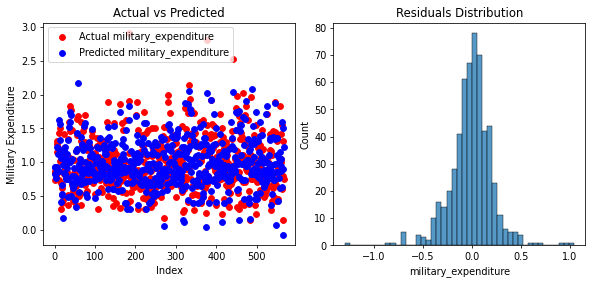

In [482]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8.4, 4), dpi=70)  # wider figure for two plots

# Left plot: scatter of actual vs predicted
ax1.scatter(range(len(Y_test)), Y_test, color='red')
ax1.scatter(range(len(Y_test)), y_pred, color='blue')
ax1.legend(['Actual military_expenditure', 'Predicted military_expenditure'])
ax1.set_title('Actual vs Predicted')
ax1.set_xlabel('Index')
ax1.set_ylabel('Military Expenditure')

# Right plot: histogram of residuals
sns.histplot(y_pred - Y_test, ax=ax2)
ax2.set_title('Residuals Distribution')

plt.tight_layout(pad=0.5)
plt.show()


***From the above scatterplot we see how close actual and predicted values are located to each other and the residuals are almost normally distributed***

In [413]:
sqrt(mean_squared_error(Y_test, y_pred))

0.2201092578989357

In [414]:
RMSE = sqrt(sum((y_pred - Y_test)**2)/Y_test.shape[0])

In [415]:
print(f"RMSE: {RMSE:.5f}")

RMSE: 0.22011


In [416]:
R2 = 1-sum((Y_test - y_pred)**2)/sum((Y_test - np.mean(Y_test))**2)

In [417]:
print(f"R2: {R2:.5f}")

R2: 0.69842


***As a result, we have a low RMSE, and a relatively good R2 score, showing us that the model predicts acceptable, but we were expecting better results. Looks like this amount of predictors we've chosen is not enough*** 

***Let's execute a Cross-Validation to check, can we find a better model***

In [418]:
param_list = {
    "hidden_layer_sizes": [50,100],
    "activation": ["identity", "logistic", "tanh", "relu"],
    "alpha": [1e-5,1e-4],
    "solver": ["lbfgs", "sgd", "adam"]
}
gridCV = GridSearchCV(estimator=MLPRegressor(), param_grid=param_list)

In [419]:
gridCV.fit(X_train, Y_train)

GridSearchCV(estimator=MLPRegressor(),
             param_grid={'activation': ['identity', 'logistic', 'tanh', 'relu'],
                         'alpha': [1e-05, 0.0001],
                         'hidden_layer_sizes': [50, 100],
                         'solver': ['lbfgs', 'sgd', 'adam']})

In [420]:
gridCV.best_estimator_

MLPRegressor(activation='tanh', hidden_layer_sizes=50, solver='lbfgs')

In [421]:
best_predict = gridCV.best_estimator_.predict(X_test)

In [422]:
sqrt(mean_squared_error(Y_test, best_predict))

0.35466141378839766

In [423]:
r2_score(Y_test, y_pred)

0.6984236661477354

***Based on the results, with the provided parameters, the best estimated model was a bit worse than our custom, standard one***

### 5.4 SVM Models


We trained a **Support Vector Machine (SVM)** classifier with an RBF kernel to capture non-linear decision boundaries between different political ideologies (leftist, rightist, centrist). Since SVMs naturally handle binary classification, we used a one-vs-one strategy for handling multiple classes. To boost performance and avoid overfitting, we used grid search with cross-validation to tune key hyperparameters like C and gamma.



In [424]:
# Prepare data
svm_features = [
    'IMF_based_exchange_rate', 'Per_capita_GNI', 'agriculture_and_hunting_fishing_isic', 'construction_isic',
    'Exports_of_goods_and_services', 'Gross_capital_formation', 'Imports_of_goods_and_services',
    'mining_manifacturing_isic', 'transport_storage_communication_isic', 'wholesale_trade_restaurant_hotel_isic',
    'gross_national_income_GNI', 'GDP', 'military_expenditure', 'Urban_population', 'Rural_population'
]
df_svm = df_log[svm_features + ['leader_ideology']].dropna()
X_svm, y_svm = df_svm[svm_features], df_svm['leader_ideology']

# Encode & split
le_svm = LabelEncoder()
y_svm_encoded = le_svm.fit_transform(y_svm)
X_train, X_test, y_train, y_test = train_test_split(X_svm, y_svm_encoded, test_size=0.2, stratify=y_svm_encoded, random_state=42)

# Scale features
scaler = StandardScaler()
X_train_scaled, X_test_scaled = scaler.fit_transform(X_train), scaler.transform(X_test)

# Train baseline SVM
svm = SVC(kernel='rbf', random_state=42)
svm.fit(X_train_scaled, y_train)
y_pred = svm.predict(X_test_scaled)


Baseline SVM Accuracy: 0.5912280701754385
              precision    recall  f1-score   support

    centrist       0.44      0.19      0.27        58
     leftist       0.59      0.78      0.67       267
    rightist       0.61      0.49      0.54       245

    accuracy                           0.59       570
   macro avg       0.55      0.48      0.49       570
weighted avg       0.58      0.59      0.57       570



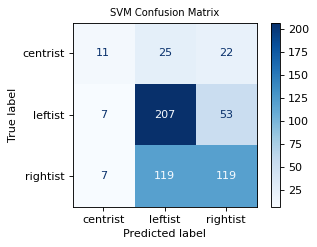

In [425]:

# Evaluate
print("Baseline SVM Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred, target_names=le_svm.classes_))

# Compact confusion matrix
fig, ax = plt.subplots(figsize=(4.2, 3), dpi=80)
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels=le_svm.classes_, cmap='Blues', ax=ax)
ax.set_title("SVM Confusion Matrix", fontsize=9)
plt.tight_layout(pad=0.4)
plt.show()


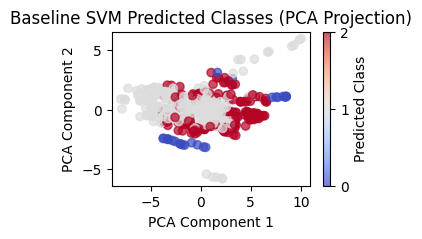

In [426]:
# Reduce to 2D for visualization using unique SVM-scaled test set
pca_svm = PCA(n_components=2)
X_svm_test_pca = pca_svm.fit_transform(X_test_scaled)

plt.figure(figsize=(3.2, 2), dpi=100)
scatter = plt.scatter(
    X_svm_test_pca[:, 0], X_svm_test_pca[:, 1],
    c=y_pred, cmap='coolwarm', alpha=0.7
)
plt.title("Baseline SVM Predicted Classes (PCA Projection)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.colorbar(scatter, ticks=[0,1,2], label='Predicted Class')
plt.show()

In [427]:
# Define the parameter grid
param_grid_svm = {
    'C': [0.1, 1, 10, 100],
    'gamma': [0.01, 0.1, 1, 10]
}

# Create and fit the GridSearchCV object with unique variables
svm_clf = SVC(kernel='rbf', decision_function_shape='ovo', random_state=42)
grid_search_svm = GridSearchCV(
    svm_clf,
    param_grid_svm,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=2
)
grid_search_svm.fit(X_svm_train_scaled, y_svm_train)

print("Best parameters:", grid_search_svm.best_params_)
print("Best cross-validation accuracy:", grid_search_svm.best_score_)

Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best parameters: {'C': 100, 'gamma': 1}
Best cross-validation accuracy: 0.8617727009832272


Tuned SVM Accuracy: 0.88
              precision    recall  f1-score   support

    centrist       0.84      0.72      0.78        58
     leftist       0.88      0.91      0.90       267
    rightist       0.89      0.89      0.89       245

    accuracy                           0.88       570
   macro avg       0.87      0.84      0.86       570
weighted avg       0.88      0.88      0.88       570



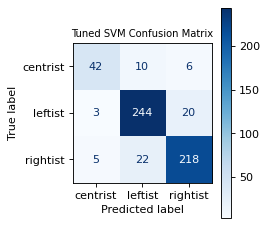

In [428]:
# Evaluate best model
y_pred_best = grid_search_svm.predict(X_svm_test_scaled)
print(f"Tuned SVM Accuracy: {accuracy_score(y_svm_test, y_pred_best):.2f}")
print(classification_report(y_svm_test, y_pred_best, target_names=le_svm.classes_))

# Compact confusion matrix
fig, ax = plt.subplots(figsize=(3.2, 3), dpi=80)
ConfusionMatrixDisplay.from_predictions(y_svm_test, y_pred_best, display_labels=le_svm.classes_, cmap='Blues', ax=ax)
ax.set_title("Tuned SVM Confusion Matrix", fontsize=9)
plt.tight_layout(pad=0.4)
plt.show()

| **Interpretation** |  |
| :--- | :--- |
| **Baseline Performance** | The default SVM struggled to classify the **centrist** class, resulting in poor precision and recall. |
| **Hyperparameter Tuning** | A grid search over `C` and `gamma` drastically improved performance by optimizing the model’s decision boundary. |
| **Post-Tuning Accuracy** | The best-tuned SVM achieved **88% test accuracy**, up from the baseline, showing substantial learning gains. |
| **Class-wise Results** | - **Centrist**: Precision = 0.84, Recall = 0.72, F1 = 0.78 – strong gains in detecting this underrepresented class.<br>- **Leftist**: Precision = 0.88, Recall = 0.91, F1 = 0.90 – reliable and accurate.<br>- **Rightist**: Precision = 0.89, Recall = 0.89, F1 = 0.89 – balanced performance. |
| **Macro-Averaged F1 Score** | Achieved a solid **0.86**, confirming consistent predictive power across all classes. |
| **Key Takeaway** | Tuning and feature engineering transformed SVM into a **robust multi-class predictor** of political ideology from macroeconomic indicators. |
| **Impact on Centrist Class** | The model now distinguishes centrists effectively, showing that even nuanced ideological categories can be captured with refined modeling. |


## <a id='6-results'></a>6. Results

| Goal                                                                | Model                                   | Accuracy | Precision (Weighted Avg) | Recall (Weighted Avg) | F1-Score (Weighted Avg) | R² / Pseudo R² | RMSE / Deviance     | Notes                   |
|---------------------------------------------------------------------|-----------------------------------------|----------|--------------------------|-----------------------|-------------------------|----------------|---------------------|-------------------------|
| Predict leader ideology using all predictors                        | Multinomial Logistic Regression         | 0.4789   | 0.43                     | 0.48                  | 0.45                    | -              | -                   |                         |
| Predict leader ideology using all predictors                        | Support Vector Machine (Baseline)       | 0.5912   | 0.58                     | 0.59                  | 0.57                    | -              | -                   |                         |
| Predict leader ideology using all predictors                        | Support Vector Machine (Tuned)          | 0.8800   | 0.88                     | 0.88                  | 0.88                    | -              | -                   |                         |
| Predict democracy status using all predictors                       | Binomial Classifier (GLM)               | 0.75   | 0.75                     | 0.75                  | 0.75                    | -              | -                   |                         |
| Predict leader ideology using all predictors                        | Neural Network (MLP, 200 units)         | 0.94   | 0.94                     | 0.94                  | 0.94                    | -              | -                   |                         |
| Predict urban population count using all predictors (regression)    | Linear Regression (Scaled Log-Features) | -        | -                        | -                     | -                       | 0.4296           | 50355127.8959 (RMSE)           |        |
| Predict urban population count using all predictors (count model)   | Quasi-Poisson Regression                | -        | -                        | -                     | -                       | 1.0            | 1.66 × 10⁹ (dev)    | Log-transformed features and target    |
| Predict urban population count using all predictors (count model)   | Negative Binomial Regression                | -        | -                        | -                     | -                       |0.68            | 80.661(dev)/ 10158405.7124(RMSE)  | Log-transformed features and target    |
| Predict military expenditure using all predictors                   | GAM         | -   |       -              |     -             |     .             |   0.346          | 0.3275406 (RMSE)        |    Log transformed target & smooth terms used with log transformed features                    |
| Predict military expenditure using all predictors                   | GAM (Transformed)         |  -  |             -        |      -            |         -         |   0.352          | 0.330655 (RMSE)        |    Yeo-Johnson transformed target & smooth terms used with log transformed features                    |
| Predict military expenditure using all predictors (regression)      | Neural Network Regressor (MLP, 200)     | –        | –                        | –                     | –                       | 0.70         | 0.22 (RMSE)          | Log-transformed features and target    |
| Predict military expenditure using all predictors (regression)      | Quadratic Model                         | –        | –                        | –                     | –                       | 0.107         |     -     | Polynomial regression, log-transformed target & features|








## <a id='7-conclusions--recommendations'></a>7. Conclusions & Recommendations

### Hypothesis Validation
1. **GDP and Rightist Ideologies**  
   ❌ No — Right-leaning governments / leader ideologies did not have any significant relationships with GDP.

2. **Leader Ideologies and Income Inequality → Military Spending**  
   ✅ Partly — Richer countries were much more likely to be democracies (Binomial GLM showed 106× higher odds) and democracies tend to have lower military spending (GAM, estimate~ -0.199). Military spending and economic indicators have non-linear but significant relationships and having a leftist ideology significantly relates to lower military spending (GAM, estimate~-0.13)

3. **Leader Ideologies, Economy and Develeopment -> Urbanization**  
   ✅ Yes — A larger urban population was tied to centrist governments (SVM feature importance +12%). Though, urban population seem to have an interesting relationship with wealth. Urbanization and GDP follows a positive relationship (%86 increase), whereas with per capita GNI (%52 decrease) follows a negative relationship (GLM Poisson). This might mean that, even though the countries have bigger economies (high GDP), individuals with high salaries tend to prefer living in the countryside. In addition, urbanization was linked to transport sector growth.

4. **Democracy and Military Spending**  
   ✅ Yes —Authoritarian regimes spend more on defense. A one-unit increase in military spending corresponds to a **21% decrease** in the odds of democracy (Binomial GLM).

### Client-Facing Recommendations

- **Support Democratic Change**  
  Encourage democratic reforms. Democracies spent 15% less on defense and have higher GDP's.

- **Tie Aid to Fair Income**  
  Link foreign aid to income equality. Higher average income cut military spending by 15.8%.

- **Target Swing Regions**  
  Prioritize centrist, fast-growing areas. GDP had an 8.3% weight in predicting ideology.

- **Invest in Transport for Citizens**  
 Urbanization is linked to both transport sector growth and high GDP.

- **Encourage leftist leaders**  
  Leftist leader ideologies are linked to lower military spending.

- **Military spending as an indicator of democratic tendencies**  
   Forecasting yearly changes in military spending might help to understand the future of countries ideologies, democratic tendencies and economic growth.

## <a id='8-ai-usage-reflection'></a>8. AI Usage Reflection


| **Aspect** | **Details** |
| :--- | :--- |
| ✅ **Efficiency Gains** | - Rapid code generation for SVM tuning and neural networks.<br>- Improved readability of GLM outputs (e.g., odds ratios with exp(β)).<br>-  **Final Outcome**: AI was used to format the full analysis into a concise 30-page deliverable. |
| ✅ **Method Clarification** | - Clear explanations of LOWESS method for residuals.<br>- Simplified breakdown of AUC-ROC trade-offs. |
| ❌ **Data Access Restrictions** | - Tools like DeepSeek and Gemini blocked use of “ideology” data due to ethical filters. |
| ❌ **Technical Errors** | - SVM initial settings (C=1000, gamma=0.001) caused overfitting.<br>- Perplexity AI returned incorrect confusion matrix code, fixed manually. |
| ❌ **Interpretation Risks** | - Misinterpretation of negative-binomial coefficients in AI output | 
| ❌ **Model Diagnostics** | - Misinterpretation of residual values and model evaluation | 
| ✅ **Best Practice: Human in the Loop** | Always verify AI-generated results and code using your own expertise. |
| ✅ **Best Practice: Ethical Use** | Avoid AI tools that restrict or bias outputs on political content. Choose tools that align with your analytical goals. |


## <a id='9-team-contributions'></a> 9. Team Contributions


This project was a collaborative effort where each member contributed their expertise to different stages of the workflow:

- **Data Selection & Cleaning:**  
  Özarslan Irmak was responsible for selecting the macroeconomic and political datasets and performed comprehensive data cleaning to ensure the dataset was reliable for analysis.

- **Exploratory Data Analysis (EDA):** 
  Batschelet Jimena conducted the exploratory data analysis, uncovering important trends, distributions, and relationships that informed subsequent modeling decisions.

- **Modeling:**  
    - Generalized Additive Model (GAM) and Poisson Model: Özarslan Irmak implemented and tuned the GAM and Poisson models.
    - Neural Networks & Binomial Model: Chichko Kostiantyn developed the neural network models and performed the Binomial model analysis.
    - Linear Regression & SVM: Batschelet Jimena was responsible for implementing the linear regression and support vector machine models.

- **Shared Responsibilities:**  
  All team members collaborated on project planning, coordination, result interpretation, report writing, and presentation preparation. Peer review and feedback were integral at every stage, ensuring high-quality and reproducible results.

**Team Members:**  
- Batschelet Jimena W.MSCIDS.2201 (<jimena.batschelet@stud.hslu.ch>)  
- Özarslan Irmak W.MSCIDS.2401 (<irmak.oezarslan@stud.hslu.ch>)  
- Chichko Kostiantyn W.MSCIDS.2401 (<kostiantyn.chichko@stud.hslu.ch>)
